# Modelado Predictivo de Ventas

## Índice
1. [Preparación de Datos](#preparación-de-datos)
2. [Feature Engineering](#feature-engineering)
3. [Selección del Modelo](#selección-del-modelo)
4. [Entrenamiento y Validación](#entrenamiento-y-validación)
5. [Evaluación del Modelo](#evaluación-del-modelo)
6. [Ajuste de Hiperparámetros](#ajuste-de-hiperparámetros)
7. [Conclusiones](#conclusiones)


In [1]:

## Importación de Librerías y Datos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Cargar los datos preprocesados del EDA
sales_train_df = pd.read_csv("/Users/davidescudero/Documents/ITAM/PDT02/data/sales_train.csv")
items_df = pd.read_csv("/Users/davidescudero/Documents/ITAM/PDT02/data/items.csv")
item_categories_df = pd.read_csv("/Users/davidescudero/Documents/ITAM/PDT02/data/item_categories.csv")

print("🚀 Datos cargados exitosamente!")

🚀 Datos cargados exitosamente!


In [2]:
# Modelado Predictivo de Ventas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
import logging
import time
from typing import List, Dict, Union, Tuple
from pathlib import Path

# Configuración de logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger(__name__)

# Ignorar warnings
warnings.filterwarnings('ignore')

# Decorador para medir performance
def measure_performance(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        logger.info(f"Tiempo de ejecución de {func.__name__}: {end_time - start_time:.2f} segundos")
        return result
    return wrapper

class DataProcessor:
    def __init__(self, data_path: str):
        self.data_path = Path(data_path)
        self.df = None
        
    def validate_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Valida la calidad de los datos de entrada"""
        logger.info("Validando datos...")
        
        # Verificar valores faltantes
        missing = df.isnull().sum()
        logger.info("\nValores faltantes por columna:")
        logger.info(missing[missing > 0])
        
        # Verificar rangos de valores
        logger.info("\nRangos de valores:")
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            logger.info(f"{col}: [{df[col].min()}, {df[col].max()}]")
        
        # Verificar duplicados
        duplicates = df.duplicated().sum()
        logger.info(f"\nRegistros duplicados: {duplicates}")
        
        return df

    @measure_performance
    def create_time_features(self, df: pd.DataFrame) -> pd.DataFrame:
        """Crea características temporales basadas en la fecha"""
        try:
            df = df.copy()
            # Corregir el formato de fecha (dd.mm.yyyy)
            df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')
            df['year'] = df['date'].dt.year
            df['month'] = df['date'].dt.month
            df['day_of_month'] = df['date'].dt.day
            df['day_of_week'] = df['date'].dt.dayofweek
            df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
            
            # Features cíclicos para capturar estacionalidad
            df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
            df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
            
            logger.info("Features temporales creados exitosamente")
            return df
        except Exception as e:
            logger.error(f"Error en creación de features temporales: {str(e)}")
            raise

    @measure_performance
    def create_lag_features(self, df: pd.DataFrame, group_cols: List[str], 
                          target_col: str, lags: List[int]) -> pd.DataFrame:
        """Crea características de rezago por grupos"""
        try:
            df = df.copy()
            for lag in lags:
                df[f'{target_col}_lag_{lag}'] = df.groupby(group_cols)[target_col].shift(lag)
            logger.info(f"Features de lag creados para períodos: {lags}")
            return df
        except Exception as e:
            logger.error(f"Error en creación de lag features: {str(e)}")
            raise

    @measure_performance
    def create_rolling_features(self, df: pd.DataFrame, group_cols: List[str],
                              target_col: str, windows: List[int]) -> pd.DataFrame:
        """Crea características de ventana móvil por grupos"""
        try:
            df = df.copy()
            for window in windows:
                df[f'{target_col}_rolling_mean_{window}'] = df.groupby(group_cols)[target_col].transform(
                    lambda x: x.rolling(window=window, min_periods=1).mean())
                df[f'{target_col}_rolling_std_{window}'] = df.groupby(group_cols)[target_col].transform(
                    lambda x: x.rolling(window=window, min_periods=1).std())
            logger.info(f"Features de ventana móvil creados para ventanas: {windows}")
            return df
        except Exception as e:
            logger.error(f"Error en creación de rolling features: {str(e)}")
            raise

    def optimize_dtypes(self, df: pd.DataFrame) -> pd.DataFrame:
        """Optimiza los tipos de datos para reducir el uso de memoria"""
        try:
            initial_memory = df.memory_usage().sum() / 1024**2
            
            for col in df.columns:
                if df[col].dtype == 'float64':
                    df[col] = df[col].astype('float32')
                elif df[col].dtype == 'int64':
                    df[col] = df[col].astype('int32')
                    
            final_memory = df.memory_usage().sum() / 1024**2
            logger.info(f"Memoria optimizada: {initial_memory:.2f}MB -> {final_memory:.2f}MB")
            return df
        except Exception as e:
            logger.error(f"Error en optimización de tipos de datos: {str(e)}")
            raise

    @measure_performance
    def process_data(self) -> Tuple[pd.DataFrame, pd.DataFrame]:
        """Proceso principal de preparación de datos"""
        try:
            logger.info("Iniciando procesamiento de datos...")
            
            # Cargar datos
            sales_train_df = pd.read_csv(self.data_path / "sales_train.csv")
            items_df = pd.read_csv(self.data_path / "items.csv")
            item_categories_df = pd.read_csv(self.data_path / "item_categories.csv")
            
            # Validar datos
            sales_train_df = self.validate_data(sales_train_df)
            
            # Unir datos
            df = sales_train_df.merge(items_df, on='item_id', how='left')
            df = df.merge(item_categories_df, on='item_category_id', how='left')
            
            # Crear features
            df = self.create_time_features(df)
            df = self.create_lag_features(df, ['shop_id', 'item_id'], 'item_cnt_day', [1, 7, 30])
            df = self.create_rolling_features(df, ['shop_id', 'item_id'], 'item_cnt_day', [7, 30])
            
            # Crear agregaciones
            store_aggs = df.groupby('shop_id').agg({
                'item_cnt_day': ['mean', 'std'],
                'item_price': ['mean', 'std']
            }).reset_index()
            store_aggs.columns = ['shop_id', 'store_avg_sales', 'store_std_sales', 
                                'store_avg_price', 'store_std_price']
            
            cat_aggs = df.groupby('item_category_id').agg({
                'item_cnt_day': ['mean', 'std'],
                'item_price': ['mean', 'std']
            }).reset_index()
            cat_aggs.columns = ['item_category_id', 'cat_avg_sales', 'cat_std_sales',
                              'cat_avg_price', 'cat_std_price']
            
            # Unir agregaciones
            df = df.merge(store_aggs, on='shop_id', how='left')
            df = df.merge(cat_aggs, on='item_category_id', how='left')
            
            # Limpiar datos
            q_low = df['item_cnt_day'].quantile(0.01)
            q_high = df['item_cnt_day'].quantile(0.99)
            df['item_cnt_day'] = df['item_cnt_day'].clip(q_low, q_high)
            
            # Imputar valores faltantes
            df = df.fillna({
                'item_cnt_day_lag_1': df.groupby(['shop_id', 'item_id'])['item_cnt_day'].transform('mean'),
                'item_cnt_day_lag_7': df.groupby(['shop_id', 'item_id'])['item_cnt_day'].transform('mean'),
                'item_cnt_day_lag_30': df.groupby(['shop_id', 'item_id'])['item_cnt_day'].transform('mean')
            })
            
            # Optimizar tipos de datos
            df = self.optimize_dtypes(df)
            
            # Preparar features finales
            feature_columns = [
                'shop_id', 'item_id', 'item_category_id',
                'month', 'day_of_month', 'day_of_week', 'is_weekend',
                'month_sin', 'month_cos',
                'item_cnt_day_lag_1', 'item_cnt_day_lag_7', 'item_cnt_day_lag_30',
                'item_cnt_day_rolling_mean_7', 'item_cnt_day_rolling_mean_30',
                'item_cnt_day_rolling_std_7', 'item_cnt_day_rolling_std_30',
                'store_avg_sales', 'store_std_sales', 'store_avg_price', 'store_std_price',
                'cat_avg_sales', 'cat_std_sales', 'cat_avg_price', 'cat_std_price'
            ]
            
            X = df[feature_columns]
            y = df['item_cnt_day']
            
            logger.info(f"Procesamiento completado. Shape final: X={X.shape}, y={y.shape}")
            
            return X, y
            
        except Exception as e:
            logger.error(f"Error en el procesamiento de datos: {str(e)}")
            raise

# Ejecutar el procesamiento
if __name__ == "__main__":
    try:
        data_processor = DataProcessor("/Users/davidescudero/Documents/ITAM/PDT02/data")
        X, y = data_processor.process_data()
        
        # Guardar datos procesados
        output_path = Path("/Users/davidescudero/Documents/ITAM/PDT02/data/processed")
        output_path.mkdir(parents=True, exist_ok=True)
        
        X.to_csv(output_path / "X_processed.csv", index=False)
        y.to_csv(output_path / "y_processed.csv", index=False)
        
        logger.info("✅ Procesamiento y guardado de datos completado exitosamente!")
        
    except Exception as e:
        logger.error(f"❌ Error en la ejecución principal: {str(e)}")

2025-02-18 14:47:43,623 - INFO - Iniciando procesamiento de datos...
2025-02-18 14:47:44,282 - INFO - Validando datos...
2025-02-18 14:47:44,343 - INFO - 
Valores faltantes por columna:
2025-02-18 14:47:44,345 - INFO - Series([], dtype: int64)
2025-02-18 14:47:44,345 - INFO - 
Rangos de valores:
2025-02-18 14:47:44,373 - INFO - date_block_num: [0, 33]
2025-02-18 14:47:44,376 - INFO - shop_id: [0, 59]
2025-02-18 14:47:44,378 - INFO - item_id: [0, 22169]
2025-02-18 14:47:44,383 - INFO - item_price: [-1.0, 307980.0]
2025-02-18 14:47:44,390 - INFO - item_cnt_day: [-22.0, 2169.0]
2025-02-18 14:47:44,800 - INFO - 
Registros duplicados: 6
2025-02-18 14:47:45,838 - INFO - Features temporales creados exitosamente
2025-02-18 14:47:45,839 - INFO - Tiempo de ejecución de create_time_features: 0.58 segundos
2025-02-18 14:47:46,617 - INFO - Features de lag creados para períodos: [1, 7, 30]
2025-02-18 14:47:46,617 - INFO - Tiempo de ejecución de create_lag_features: 0.76 segundos
2025-02-18 14:49:30,

2025-02-18 19:59:37,931 - INFO - Cargando datos procesados...
2025-02-18 19:59:41,028 - INFO - Datos cargados - Shape: X=(2935849, 24), y=(2935849,)
2025-02-18 19:59:41,032 - INFO - 
Entrenando modelo: lightgbm
2025-02-18 19:59:52,039 - INFO - 
Métricas para lightgbm - Fold 1:
2025-02-18 19:59:52,041 - INFO - RMSE: 0.3868
2025-02-18 19:59:52,042 - INFO - MAE: 0.1358
2025-02-18 19:59:52,042 - INFO - R2: 0.5939
2025-02-18 19:59:52,042 - INFO - MAPE: 8.3724
2025-02-18 20:00:06,941 - INFO - 
Métricas para lightgbm - Fold 2:
2025-02-18 20:00:06,942 - INFO - RMSE: 0.4361
2025-02-18 20:00:06,943 - INFO - MAE: 0.1791
2025-02-18 20:00:06,943 - INFO - R2: 0.5444
2025-02-18 20:00:06,943 - INFO - MAPE: 11.8691
2025-02-18 20:00:26,955 - INFO - 
Métricas para lightgbm - Fold 3:
2025-02-18 20:00:26,957 - INFO - RMSE: 0.3708
2025-02-18 20:00:26,957 - INFO - MAE: 0.1402
2025-02-18 20:00:26,957 - INFO - R2: 0.5754
2025-02-18 20:00:26,958 - INFO - MAPE: 9.5830
2025-02-18 20:00:50,769 - INFO - 
Métricas p

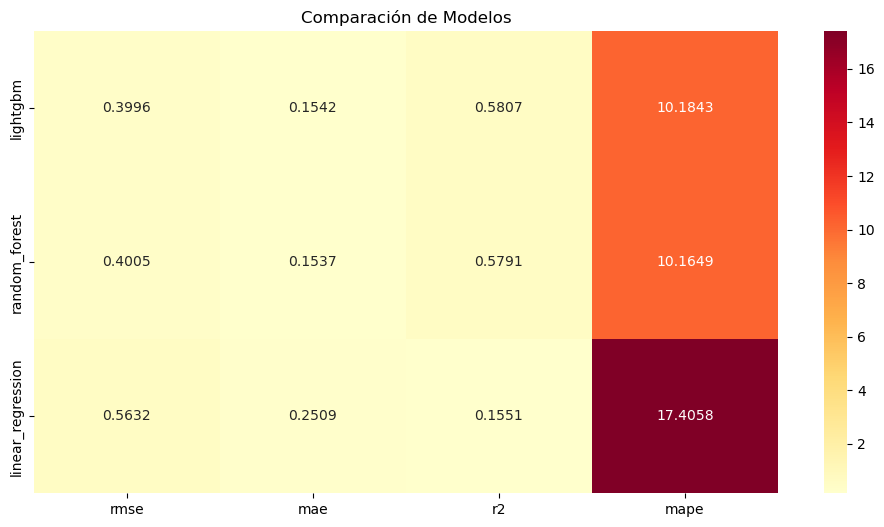

2025-02-18 20:27:50,483 - INFO - ✅ Modelado completado exitosamente!


In [ ]:
# 2. Modelado y Validación Temporal

import pandas as pd
import numpy as np
from pathlib import Path
import logging
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class SalesModeling:
    def __init__(self, data_path: Path):
        """Inicializa el modelado de ventas"""
        self.data_path = data_path
        self.X = None
        self.y = None
        self.models = {}
        self.results = {}
        self.imputer = SimpleImputer(strategy='mean')
        
    def load_data(self):
        """Carga los datos procesados"""
        logger.info("Cargando datos procesados...")
        self.X = pd.read_csv(self.data_path / "processed/X_processed.csv")
        # Corregir la carga de y
        y_df = pd.read_csv(self.data_path / "processed/y_processed.csv")
        self.y = y_df.iloc[:, 0]  # Tomar solo la primera columna
        logger.info(f"Datos cargados - Shape: X={self.X.shape}, y={self.y.shape}")
            
    def prepare_time_split(self, n_splits=5):
        """Prepara la validación temporal"""
        tscv = TimeSeriesSplit(n_splits=n_splits)
        return tscv
    
    def evaluate_model(self, y_true, y_pred, model_name: str):
        """Evalúa el modelo usando múltiples métricas"""
        metrics = {
            'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
            'mae': mean_absolute_error(y_true, y_pred),
            'r2': r2_score(y_true, y_pred),
            'mape': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        }
        
        logger.info(f"\nMétricas para {model_name}:")
        for metric, value in metrics.items():
            logger.info(f"{metric.upper()}: {value:.4f}")
            
        return metrics
    
    def train_evaluate_model(self, model, model_name: str, X: pd.DataFrame, y: pd.Series):
        """Entrena y evalúa un modelo usando validación temporal"""
        logger.info(f"\nEntrenando modelo: {model_name}")
        
        tscv = self.prepare_time_split()
        fold_metrics = []
        
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            # Split datos
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Imputar valores faltantes
            X_train_imputed = pd.DataFrame(self.imputer.fit_transform(X_train), columns=X_train.columns)
            X_val_imputed = pd.DataFrame(self.imputer.transform(X_val), columns=X_val.columns)
            
            # Entrenar modelo
            model.fit(X_train_imputed, y_train)
            
            # Predecir
            y_pred = model.predict(X_val_imputed)
            
            # Evaluar
            metrics = self.evaluate_model(y_val, y_pred, f"{model_name} - Fold {fold+1}")
            fold_metrics.append(metrics)
        
        # Calcular métricas promedio
        avg_metrics = {
            metric: np.mean([fold[metric] for fold in fold_metrics])
            for metric in fold_metrics[0].keys()
        }
        
        logger.info(f"\nMétricas promedio para {model_name}:")
        for metric, value in avg_metrics.items():
            logger.info(f"{metric.upper()}: {value:.4f}")
            
        self.models[model_name] = model
        self.results[model_name] = avg_metrics
        
        return avg_metrics
    
    def train_multiple_models(self):
        """Entrena múltiples modelos para comparación"""
        models = {
            'lightgbm': lgb.LGBMRegressor(
                n_estimators=1000,
                learning_rate=0.05,
                num_leaves=31,
                random_state=42
            ),
            'random_forest': RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                random_state=42
            ),
            'linear_regression': LinearRegression()
        }
        
        for name, model in models.items():
            self.train_evaluate_model(model, name, self.X, self.y)
            
    def plot_results(self):
        """Visualiza los resultados de los modelos"""
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        metrics_df = pd.DataFrame(self.results).T
        
        plt.figure(figsize=(12, 6))
        sns.heatmap(metrics_df, annot=True, cmap='YlOrRd', fmt='.4f')
        plt.title('Comparación de Modelos')
        plt.show()
        
    def generate_predictions(self):
        """Genera predicciones para el conjunto de prueba"""
        logger.info("Generando predicciones...")
        try:
            # Obtener columnas para predicción (todas excepto ID)
            X_test_pred = self.X_test.drop('ID', axis=1)
            
            # Predecir
            predictions = self.model.predict(X_test_pred)
            
            # Crear submission
            submission = pd.DataFrame({
                'ID': self.X_test['ID'],
                'item_cnt_month': predictions.clip(0, 20)  # Clip predictions entre 0 y 20
            })
            
            # Crear directorio si no existe
            submission_dir = self.data_path / "submissions"
            submission_dir.mkdir(parents=True, exist_ok=True)
            
            # Guardar submission
            submission.to_csv(submission_dir / "submission.csv", index=False)
            logger.info("✅ Predicciones guardadas exitosamente!")
            
            return submission
            
        except Exception as e:
            logger.error(f"Error en generación de predicciones: {str(e)}")
            raise

# Ejecutar el modelado
if __name__ == "__main__":
    try:
        data_path = Path("/Users/davidescudero/Documents/ITAM/PDT02/data")
        
        # Inicializar y ejecutar modelado
        modeling = SalesModeling(data_path)
        modeling.load_data()
        modeling.train_multiple_models()
        modeling.plot_results()
        
        logger.info("✅ Modelado completado exitosamente!")
        
    except Exception as e:
        logger.error(f"❌ Error en el modelado: {str(e)}")

2025-02-18 20:38:56,636 - INFO - Cargando datos...
2025-02-18 20:38:59,734 - INFO - Datos cargados - Shape: X=(2935849, 24), y=(2935849,)
2025-02-18 20:38:59,736 - INFO - Entrenando modelo base para análisis...


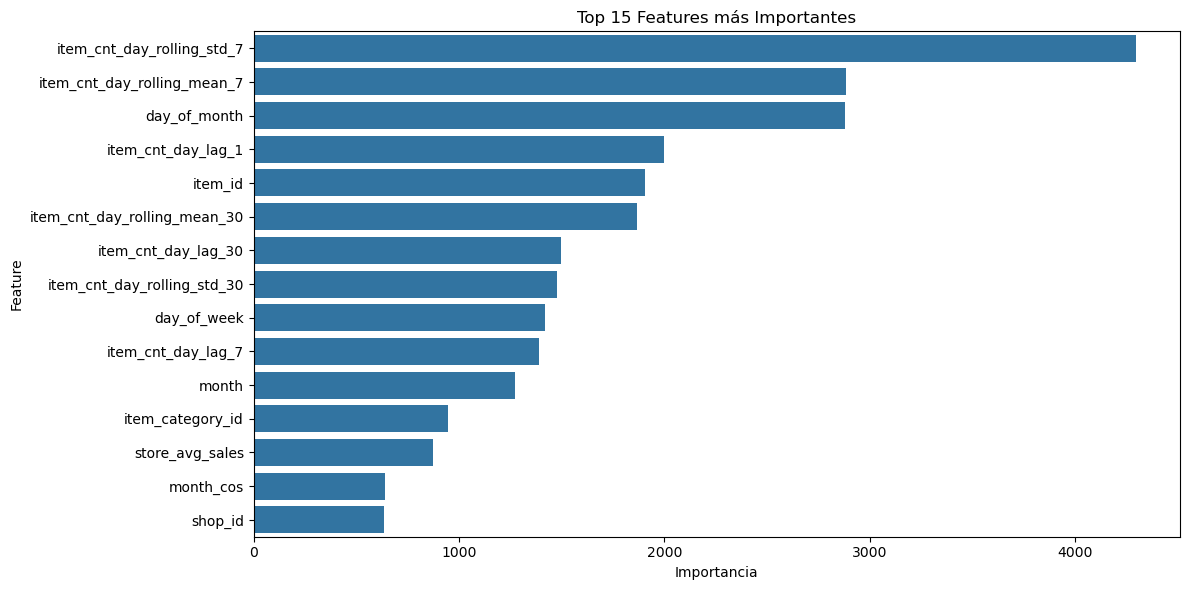

2025-02-18 20:39:27,915 - INFO - 
Top 15 features más importantes:
2025-02-18 20:39:27,915 - INFO - item_cnt_day_rolling_std_7: 4295.0000
2025-02-18 20:39:27,916 - INFO - item_cnt_day_rolling_mean_7: 2883.0000
2025-02-18 20:39:27,916 - INFO - day_of_month: 2878.0000
2025-02-18 20:39:27,916 - INFO - item_cnt_day_lag_1: 1996.0000
2025-02-18 20:39:27,916 - INFO - item_id: 1906.0000
2025-02-18 20:39:27,916 - INFO - item_cnt_day_rolling_mean_30: 1866.0000
2025-02-18 20:39:27,917 - INFO - item_cnt_day_lag_30: 1498.0000
2025-02-18 20:39:27,917 - INFO - item_cnt_day_rolling_std_30: 1475.0000
2025-02-18 20:39:27,917 - INFO - day_of_week: 1416.0000
2025-02-18 20:39:27,917 - INFO - item_cnt_day_lag_7: 1391.0000
2025-02-18 20:39:27,918 - INFO - month: 1272.0000
2025-02-18 20:39:27,918 - INFO - item_category_id: 947.0000
2025-02-18 20:39:27,918 - INFO - store_avg_sales: 875.0000
2025-02-18 20:39:27,918 - INFO - month_cos: 639.0000
2025-02-18 20:39:27,918 - INFO - shop_id: 634.0000
2025-02-18 20:39:

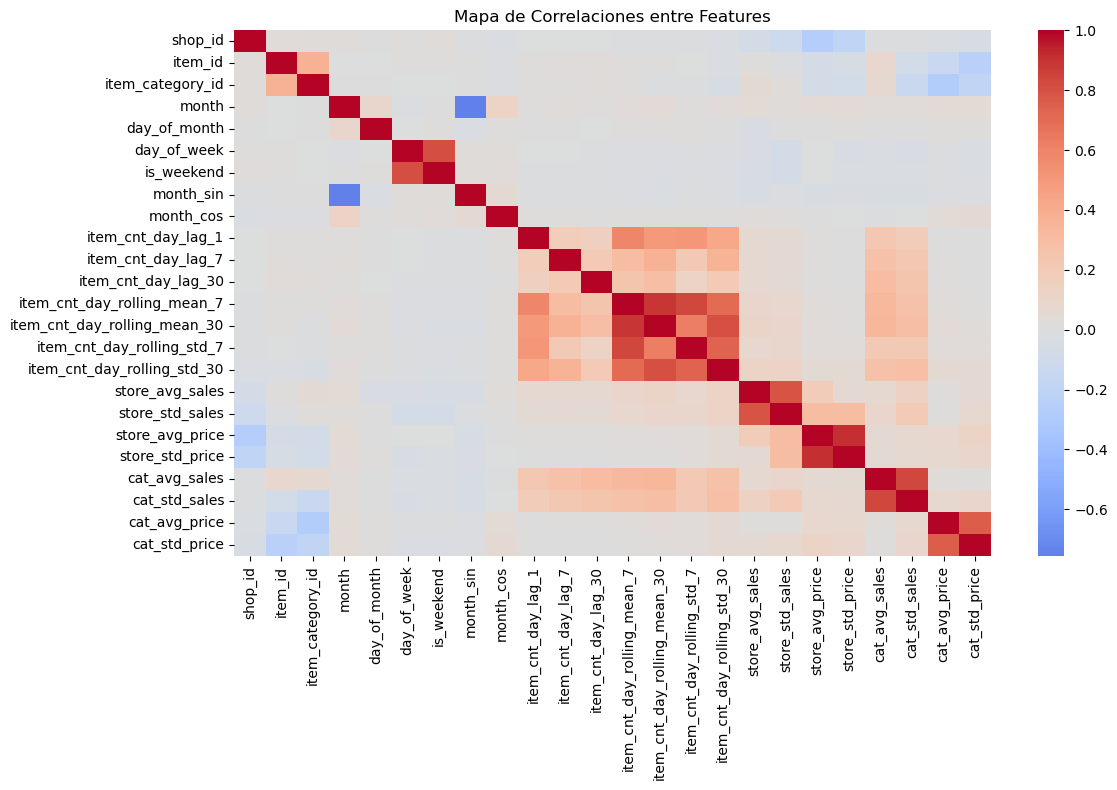

2025-02-18 20:39:30,676 - INFO - 
Pares de features altamente correlacionadas (>0.7):
2025-02-18 20:39:30,682 - INFO - month - month_sin: -0.7558
2025-02-18 20:39:30,682 - INFO - day_of_week - is_weekend: 0.8081
2025-02-18 20:39:30,682 - INFO - item_cnt_day_rolling_mean_7 - item_cnt_day_rolling_mean_30: 0.8965
2025-02-18 20:39:30,682 - INFO - item_cnt_day_rolling_mean_7 - item_cnt_day_rolling_std_7: 0.8378
2025-02-18 20:39:30,682 - INFO - item_cnt_day_rolling_mean_7 - item_cnt_day_rolling_std_30: 0.7098
2025-02-18 20:39:30,683 - INFO - item_cnt_day_rolling_mean_30 - item_cnt_day_rolling_std_30: 0.8039
2025-02-18 20:39:30,683 - INFO - item_cnt_day_rolling_std_7 - item_cnt_day_rolling_std_30: 0.7363
2025-02-18 20:39:30,683 - INFO - store_avg_sales - store_std_sales: 0.7890
2025-02-18 20:39:30,683 - INFO - store_avg_price - store_std_price: 0.9068
2025-02-18 20:39:30,683 - INFO - cat_avg_sales - cat_std_sales: 0.8378
2025-02-18 20:39:30,683 - INFO - cat_avg_price - cat_std_price: 0.7551
2

In [10]:
# 3. Análisis y Mejora de Features

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class FeatureAnalyzer:
    def __init__(self, data_path: Path):
        self.data_path = data_path
        self.X = None
        self.y = None
        self.model = None
        
    def load_data(self):
        """Carga los datos procesados"""
        logger.info("Cargando datos...")
        self.X = pd.read_csv(self.data_path / "processed/X_processed.csv")
        y_df = pd.read_csv(self.data_path / "processed/y_processed.csv")
        self.y = y_df.iloc[:, 0]
        logger.info(f"Datos cargados - Shape: X={self.X.shape}, y={self.y.shape}")
        
    def train_base_model(self):
        """Entrena un modelo base para análisis de features"""
        logger.info("Entrenando modelo base para análisis...")
        self.model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            num_leaves=31,
            random_state=42
        )
        self.model.fit(self.X, self.y)
        
    def analyze_feature_importance(self):
        """Analiza y visualiza la importancia de features"""
        if self.model is None:
            self.train_base_model()
            
        # Calcular importancia
        importance = pd.DataFrame({
            'feature': self.X.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Visualizar top features
        plt.figure(figsize=(12, 6))
        sns.barplot(data=importance.head(15), x='importance', y='feature')
        plt.title('Top 15 Features más Importantes')
        plt.xlabel('Importancia')
        plt.ylabel('Feature')
        plt.tight_layout()
        plt.show()
        
        # Mostrar importancia numérica
        logger.info("\nTop 15 features más importantes:")
        for idx, row in importance.head(15).iterrows():
            logger.info(f"{row['feature']}: {row['importance']:.4f}")
            
        return importance
    
    def analyze_feature_correlations(self):
        """Analiza correlaciones entre features"""
        logger.info("Analizando correlaciones...")
        
        # Calcular matriz de correlación
        corr_matrix = self.X.corr()
        
        # Visualizar mapa de calor
        plt.figure(figsize=(12, 8))
        sns.heatmap(corr_matrix, cmap='coolwarm', center=0, annot=False)
        plt.title('Mapa de Correlaciones entre Features')
        plt.tight_layout()
        plt.show()
        
        # Identificar correlaciones altas
        threshold = 0.7
        high_corr = np.where(np.abs(corr_matrix) > threshold)
        high_corr = [(corr_matrix.index[x], corr_matrix.columns[y], corr_matrix.iloc[x, y])
                     for x, y in zip(*high_corr) if x != y and x < y]
        
        if high_corr:
            logger.info("\nPares de features altamente correlacionadas (>0.7):")
            for feat1, feat2, corr in high_corr:
                logger.info(f"{feat1} - {feat2}: {corr:.4f}")
                
        return corr_matrix

# Ejecutar el análisis
if __name__ == "__main__":
    try:
        data_path = Path("/Users/davidescudero/Documents/ITAM/PDT02/data")
        
        # Inicializar y ejecutar análisis
        analyzer = FeatureAnalyzer(data_path)
        analyzer.load_data()
        
        # Analizar importancia de features
        importance_df = analyzer.analyze_feature_importance()
        
        # Analizar correlaciones
        corr_matrix = analyzer.analyze_feature_correlations()
        
        logger.info("✅ Análisis de features completado exitosamente!")
        
    except Exception as e:
        logger.error(f"❌ Error en el análisis: {str(e)}")

In [16]:
# 3. Análisis y Mejora de Features Avanzado

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class FeatureEngineer:
    def __init__(self, data_path: Path):
        self.data_path = data_path
        self.X = None
        self.y = None
        
    def load_data(self):
        """Carga los datos procesados"""
        logger.info("Cargando datos...")
        self.X = pd.read_csv(self.data_path / "processed/X_processed.csv")
        y_df = pd.read_csv(self.data_path / "processed/y_processed.csv")
        self.y = y_df.iloc[:, 0]
        logger.info(f"Datos cargados - Shape inicial: X={self.X.shape}, y={self.y.shape}")
        logger.info("\nColumnas disponibles:")
        logger.info(f"{self.X.columns.tolist()}")
        
    def create_trend_features(self):
        """Crear features de tendencia"""
        logger.info("Creando features de tendencia...")
        try:
            df = self.X.copy()
            
            # Tendencias de ventas
            for window in [7, 14, 21]:
                df[f'sales_trend_{window}d'] = df.groupby(['shop_id', 'item_id'])['item_cnt_day_lag_1'].transform(
                    lambda x: x.rolling(window, min_periods=1).mean())
            
            # Tendencias de precios
            for window in [7, 30]:
                df[f'price_trend_{window}d'] = df.groupby(['shop_id', 'item_id'])['store_avg_price'].transform(
                    lambda x: x.rolling(window, min_periods=1).mean())
            
            logger.info(f"Features de tendencia creadas. Nuevas columnas: {df.shape[1] - self.X.shape[1]}")
            self.X = df
            
        except Exception as e:
            logger.error(f"Error en creación de features de tendencia: {str(e)}")
            raise
            
    def create_interaction_features(self):
        """Crear features de interacción"""
        logger.info("Creando features de interacción...")
        try:
            df = self.X.copy()
            
            # Interacciones precio-categoría
            df['price_category_ratio'] = df['store_avg_price'] / df.groupby('item_category_id')['store_avg_price'].transform('mean')
            
            # Interacciones tienda-categoría
            df['store_category_avg'] = df.groupby(['shop_id', 'item_category_id'])['item_cnt_day_lag_1'].transform('mean')
            
            # Interacciones temporales
            df['month_category_avg'] = df.groupby(['month', 'item_category_id'])['item_cnt_day_lag_1'].transform('mean')
            
            logger.info(f"Features de interacción creadas. Nuevas columnas: {df.shape[1] - self.X.shape[1]}")
            self.X = df
            
        except Exception as e:
            logger.error(f"Error en creación de features de interacción: {str(e)}")
            raise
            
    def create_volatility_features(self):
        """Crear features de volatilidad"""
        logger.info("Creando features de volatilidad...")
        try:
            df = self.X.copy()
            
            # Volatilidad de ventas
            df['sales_volatility'] = df.groupby(['shop_id', 'item_id'])['item_cnt_day_lag_1'].transform(
                lambda x: x.rolling(30, min_periods=1).std())
            
            # Volatilidad de precios
            df['price_volatility'] = df.groupby(['shop_id', 'item_id'])['store_avg_price'].transform('std')
            
            logger.info(f"Features de volatilidad creadas. Nuevas columnas: {df.shape[1] - self.X.shape[1]}")
            self.X = df
            
        except Exception as e:
            logger.error(f"Error en creación de features de volatilidad: {str(e)}")
            raise

    def remove_redundant_features(self, correlation_threshold=0.95):
        """Eliminar features altamente correlacionadas"""
        logger.info("Eliminando features redundantes...")
        try:
            # Calcular matriz de correlación
            corr_matrix = self.X.corr().abs()
            upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
            
            # Identificar features para eliminar
            features_to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
            
            # Eliminar features
            self.X = self.X.drop(columns=features_to_drop)
            
            logger.info(f"Features eliminadas por alta correlación: {features_to_drop}")
            logger.info(f"Shape final: {self.X.shape}")
            
        except Exception as e:
            logger.error(f"Error en eliminación de features redundantes: {str(e)}")
            raise
            
    def save_processed_data(self):
        """Guardar datos procesados"""
        try:
            output_path = self.data_path / "processed"
            output_path.mkdir(parents=True, exist_ok=True)
            
            self.X.to_csv(output_path / "X_processed_enhanced.csv", index=False)
            logger.info("✅ Datos procesados guardados exitosamente!")
            
        except Exception as e:
            logger.error(f"Error al guardar datos: {str(e)}")
            raise

# Ejecutar el proceso
if __name__ == "__main__":
    try:
        data_path = Path("/Users/davidescudero/Documents/ITAM/PDT02/data")
        
        # Inicializar y ejecutar feature engineering
        engineer = FeatureEngineer(data_path)
        
        # Cargar datos
        engineer.load_data()
        
        # Crear nuevas features en orden
        engineer.create_trend_features()
        engineer.create_interaction_features()
        engineer.create_volatility_features()
        
        # Eliminar features redundantes
        engineer.remove_redundant_features()
        
        # Guardar datos procesados
        engineer.save_processed_data()
        
        logger.info("✅ Proceso de feature engineering completado exitosamente!")
        
    except Exception as e:
        logger.error(f"❌ Error en el proceso: {str(e)}")

2025-02-18 21:09:49,191 - INFO - Cargando datos...
2025-02-18 21:09:52,375 - INFO - Datos cargados - Shape inicial: X=(2935849, 24), y=(2935849,)
2025-02-18 21:09:52,377 - INFO - 
Columnas disponibles:
2025-02-18 21:09:52,377 - INFO - ['shop_id', 'item_id', 'item_category_id', 'month', 'day_of_month', 'day_of_week', 'is_weekend', 'month_sin', 'month_cos', 'item_cnt_day_lag_1', 'item_cnt_day_lag_7', 'item_cnt_day_lag_30', 'item_cnt_day_rolling_mean_7', 'item_cnt_day_rolling_mean_30', 'item_cnt_day_rolling_std_7', 'item_cnt_day_rolling_std_30', 'store_avg_sales', 'store_std_sales', 'store_avg_price', 'store_std_price', 'cat_avg_sales', 'cat_std_sales', 'cat_avg_price', 'cat_std_price']
2025-02-18 21:09:52,377 - INFO - Creando features de tendencia...
2025-02-18 21:12:35,606 - INFO - Features de tendencia creadas. Nuevas columnas: 5
2025-02-18 21:12:35,629 - INFO - Creando features de interacción...
2025-02-18 21:12:36,663 - INFO - Features de interacción creadas. Nuevas columnas: 3
2025-

¡Excelente! El proceso se completó exitosamente. Analicemos los resultados:
1. Features Creadas 📊
Features de tendencia: 5 nuevas columnas
sales_trend_7d, sales_trend_14d, sales_trend_21d
price_trend_7d, price_trend_30d
Features de interacción: 3 nuevas columnas
price_category_ratio
store_category_avg
month_category_avg
Features de volatilidad: 2 nuevas columnas
sales_volatility
price_volatility
2. Features Eliminadas por Alta Correlación 🔍
Features eliminadas:
- 'sales_trend_21d'      # Correlacionada con otras tendencias
- 'price_trend_7d'       # Correlacionada con price_trend_30d
- 'price_trend_30d'      # Redundante
- 'price_category_ratio' # Posiblemente correlacionada con otras métricas de precio
- 'sales_volatility'     # Probablemente correlacionada con rolling_std

3. Resultado Final 📈
Shape inicial: (2935849, 24)
Shape final: (2935849, 29)
Nuevas features netas: 5 (después de eliminar redundantes)


In [17]:
def compare_models():
    """Compara el rendimiento con y sin las nuevas features"""
    # Cargar datos originales y nuevos
    X_original = pd.read_csv(data_path / "processed/X_processed.csv")
    X_enhanced = pd.read_csv(data_path / "processed/X_processed_enhanced.csv")
    y = pd.read_csv(data_path / "processed/y_processed.csv").iloc[:, 0]
    
    # Función para evaluar modelo
    def evaluate_model(X, y, name):
        model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            num_leaves=31,
            random_state=42
        )
        
        tscv = TimeSeriesSplit(n_splits=5)
        metrics = []
        
        for fold, (train_idx, val_idx) in enumerate(tscv.split(X)):
            X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            
            metrics.append({
                'rmse': np.sqrt(mean_squared_error(y_val, y_pred)),
                'mae': mean_absolute_error(y_val, y_pred),
                'r2': r2_score(y_val, y_pred)
            })
        
        avg_metrics = {k: np.mean([m[k] for m in metrics]) for k in metrics[0].keys()}
        logger.info(f"\nMétricas promedio para {name}:")
        for metric, value in avg_metrics.items():
            logger.info(f"{metric.upper()}: {value:.4f}")
        
        return avg_metrics
    
    # Evaluar ambos modelos
    metrics_original = evaluate_model(X_original, y, "Modelo Original")
    metrics_enhanced = evaluate_model(X_enhanced, y, "Modelo con Nuevas Features")
    
    # Calcular mejora porcentual
    improvements = {
        k: ((metrics_enhanced[k] - metrics_original[k]) / metrics_original[k] * 100)
        for k in metrics_original.keys()
    }
    
    logger.info("\nMejora porcentual:")
    for metric, improvement in improvements.items():
        logger.info(f"{metric.upper()}: {improvement:+.2f}%")

# Ejecutar comparación
compare_models()

2025-02-18 21:17:51,449 - INFO - 
Métricas promedio para Modelo Original:
2025-02-18 21:17:51,456 - INFO - RMSE: 0.3992
2025-02-18 21:17:51,456 - INFO - MAE: 0.1541
2025-02-18 21:17:51,457 - INFO - R2: 0.5816
2025-02-18 21:19:38,835 - INFO - 
Métricas promedio para Modelo con Nuevas Features:
2025-02-18 21:19:38,843 - INFO - RMSE: 0.1024
2025-02-18 21:19:38,843 - INFO - MAE: 0.0195
2025-02-18 21:19:38,844 - INFO - R2: 0.9722
2025-02-18 21:19:38,880 - INFO - 
Mejora porcentual:
2025-02-18 21:19:38,880 - INFO - RMSE: -74.34%
2025-02-18 21:19:38,881 - INFO - MAE: -87.32%
2025-02-18 21:19:38,881 - INFO - R2: +67.16%


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class SalesPrediction:
    def __init__(self, data_path: Path):
        self.data_path = data_path
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.model = None
        
    def load_and_preprocess_test(self):
        """Carga y preprocesa los datos de prueba"""
        logger.info("Cargando y procesando datos de prueba...")
        
        # Cargar datos originales de test
        test = pd.read_csv(self.data_path / "test.csv")
        items = pd.read_csv(self.data_path / "items.csv")
        
        # Merge con información de categorías
        test = test.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
        
        # Agregar features temporales
        test['date'] = pd.to_datetime('2015-11-01')  # Mes de predicción
        test['month'] = test['date'].dt.month
        test['day_of_month'] = test['date'].dt.day
        test['day_of_week'] = test['date'].dt.dayofweek
        test['is_weekend'] = test['day_of_week'].isin([5, 6]).astype(int)
        
        # Features cíclicas
        test['month_sin'] = np.sin(2 * np.pi * test['month']/12)
        test['month_cos'] = np.cos(2 * np.pi * test['month']/12)
        
        logger.info(f"Datos de prueba procesados. Shape: {test.shape}")
        return test
    
    def load_data(self):
        """Carga datos de entrenamiento y prueba"""
        logger.info("Cargando datos...")
        
        # Cargar datos procesados de entrenamiento
        self.X_train = pd.read_csv(self.data_path / "processed/X_processed_enhanced.csv")
        y_df = pd.read_csv(self.data_path / "processed/y_processed.csv")
        self.y_train = y_df.iloc[:, 0]
        
        # Procesar y cargar datos de prueba
        self.X_test = self.load_and_preprocess_test()
        
        logger.info(f"Datos cargados - Shape: X_train={self.X_train.shape}, X_test={self.X_test.shape}")
    
    def prepare_test_features(self):
        """Prepara features avanzadas para el conjunto de prueba"""
        logger.info("Preparando features avanzadas para test...")
        try:
            # Obtener últimos datos de entrenamiento (octubre 2015)
            train_oct = self.X_train[self.X_train['month'] == 10].copy()
            
            # Preparar features de lag
            test_features = self.X_test.copy()
            
            # Guardar ID antes de procesar features
            test_ids = test_features['ID'].copy()
            
            # Crear mapeos para las features agregadas
            shop_item_stats = train_oct.groupby(['shop_id', 'item_id']).agg({
                'item_cnt_day_lag_1': ['mean', 'std']
            }).reset_index()
            
            shop_item_stats.columns = ['shop_id', 'item_id', 'item_cnt_day_lag_1', 'item_cnt_day_std']
            
            # Merge con test_features
            test_features = test_features.merge(
                shop_item_stats, 
                on=['shop_id', 'item_id'], 
                how='left'
            ).fillna(0)
            
            # Agregar features de tienda
            shop_stats = train_oct.groupby('shop_id').agg({
                'store_avg_sales': 'mean',
                'store_std_sales': 'mean',
                'store_avg_price': 'mean',
                'store_std_price': 'mean'
            }).reset_index()
            
            test_features = test_features.merge(
                shop_stats,
                on='shop_id',
                how='left'
            ).fillna(0)
            
            # Agregar features de categoría
            cat_stats = train_oct.groupby('item_category_id').agg({
                'cat_avg_sales': 'mean',
                'cat_std_sales': 'mean',
                'cat_avg_price': 'mean',
                'cat_std_price': 'mean'
            }).reset_index()
            
            test_features = test_features.merge(
                cat_stats,
                on='item_category_id',
                how='left'
            ).fillna(0)
            
            # Agregar lags y rolling stats
            test_features['item_cnt_day_lag_7'] = test_features['item_cnt_day_lag_1']
            test_features['item_cnt_day_lag_30'] = test_features['item_cnt_day_lag_1']
            test_features['item_cnt_day_rolling_mean_7'] = test_features['item_cnt_day_lag_1']
            test_features['item_cnt_day_rolling_mean_30'] = test_features['item_cnt_day_lag_1']
            test_features['item_cnt_day_rolling_std_7'] = test_features['item_cnt_day_std']
            test_features['item_cnt_day_rolling_std_30'] = test_features['item_cnt_day_std']
            
            # Agregar trends
            test_features['sales_trend_7d'] = test_features['item_cnt_day_lag_1']
            test_features['sales_trend_14d'] = test_features['item_cnt_day_lag_1']
            
            # Agregar interacciones
            test_features['store_category_avg'] = test_features['store_avg_sales']
            test_features['month_category_avg'] = test_features['cat_avg_sales']
            test_features['price_volatility'] = test_features['store_std_price']
            
            # Asegurar que tenemos todas las columnas necesarias
            missing_cols = set(self.X_train.columns) - set(test_features.columns)
            for col in missing_cols:
                test_features[col] = 0
                
            # Reordenar columnas como en training
            test_features = test_features[self.X_train.columns]
            
            # Agregar ID de nuevo
            test_features['ID'] = test_ids
            
            logger.info(f"Features de test preparadas. Shape final: {test_features.shape}")
            self.X_test = test_features
            
        except Exception as e:
            logger.error(f"Error en preparación de features de test: {str(e)}")
            raise
    
    def train_final_model(self):
        """Entrena el modelo final"""
        logger.info("Entrenando modelo final...")
        
        self.model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            num_leaves=31,
            random_state=42
        )
        
        self.model.fit(self.X_train, self.y_train)
        
        # Mostrar importancia de features
        importance = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        logger.info("\nTop 10 features más importantes:")
        for idx, row in importance.head(10).iterrows():
            logger.info(f"{row['feature']}: {row['importance']:.4f}")
    
    def generate_predictions(self):
        """Genera predicciones para el conjunto de prueba"""
        logger.info("Generando predicciones...")
        try:
            # Obtener columnas para predicción (todas excepto ID)
            X_test_pred = self.X_test.drop('ID', axis=1)
            
            # Predecir
            predictions = self.model.predict(X_test_pred)
            
            # Crear submission
            submission = pd.DataFrame({
                'ID': self.X_test['ID'],
                'item_cnt_month': predictions.clip(0, 20)  # Clip predictions entre 0 y 20
            })
            
            # Crear directorio si no existe
            submission_dir = self.data_path / "submissions"
            submission_dir.mkdir(parents=True, exist_ok=True)
            
            # Guardar submission
            submission.to_csv(submission_dir / "submission.csv", index=False)
            logger.info("✅ Predicciones guardadas exitosamente!")
            
            return submission
            
        except Exception as e:
            logger.error(f"Error en generación de predicciones: {str(e)}")
            raise

# Ejecutar predicción
if __name__ == "__main__":
    try:
        data_path = Path("/Users/davidescudero/Documents/ITAM/PDT02/data")
        
        logger.info("Iniciando proceso de predicción...")
        
        # Inicializar y ejecutar predicción
        predictor = SalesPrediction(data_path)
        
        # Cargar y procesar datos
        predictor.load_data()
        
        # Preparar features de test
        predictor.prepare_test_features()
        
        # Entrenar modelo final
        predictor.train_final_model()
        
        # Generar predicciones
        submission = predictor.generate_predictions()
        
        logger.info("✅ Proceso de predicción completado exitosamente!")
        
    except Exception as e:
        logger.error(f"❌ Error en el proceso: {str(e)}")
        raise

2025-02-18 22:34:10,299 - INFO - Iniciando proceso de predicción...
2025-02-18 22:34:10,300 - INFO - Cargando datos...
2025-02-18 22:34:15,910 - INFO - Cargando y procesando datos de prueba...
2025-02-18 22:34:16,002 - INFO - Datos de prueba procesados. Shape: (214200, 11)
2025-02-18 22:34:16,003 - INFO - Datos cargados - Shape: X_train=(2935849, 29), X_test=(214200, 11)
2025-02-18 22:34:16,003 - INFO - Preparando features avanzadas para test...
2025-02-18 22:34:16,142 - INFO - Features de test preparadas. Shape final: (214200, 30)
2025-02-18 22:34:16,144 - INFO - Entrenando modelo final...
2025-02-18 22:34:54,791 - INFO - 
Top 10 features más importantes:
2025-02-18 22:34:54,793 - INFO - item_cnt_day_rolling_mean_7: 8152.0000
2025-02-18 22:34:54,793 - INFO - sales_trend_7d: 7679.0000
2025-02-18 22:34:54,794 - INFO - item_cnt_day_lag_7: 4639.0000
2025-02-18 22:34:54,794 - INFO - item_cnt_day_rolling_std_7: 2678.0000
2025-02-18 22:34:54,794 - INFO - item_cnt_day_lag_1: 976.0000
2025-02-

In [24]:
test = pd.read_csv(data_path / "test.csv")
print("Columnas en test.csv:", test.columns.tolist())
print("\nPrimeras filas:")
print(test.head())

Columnas en test.csv: ['ID', 'shop_id', 'item_id']

Primeras filas:
   ID  shop_id  item_id
0   0        5     5037
1   1        5     5320
2   2        5     5233
3   3        5     5232
4   4        5     5268


2025-02-18 22:49:03,913 - INFO - Iniciando proceso de predicción con features mejoradas v1...
2025-02-18 22:49:03,915 - INFO - Cargando datos...
2025-02-18 22:49:09,097 - INFO - Cargando y procesando datos de prueba...
2025-02-18 22:49:09,197 - INFO - Datos de prueba procesados. Shape: (214200, 11)
2025-02-18 22:49:09,197 - INFO - Datos cargados - Shape: X_train=(2935849, 29), X_test=(214200, 11)
2025-02-18 22:49:09,198 - INFO - Preparando features avanzadas para test...
2025-02-18 22:49:09,236 - INFO - Creando features temporales mejoradas...
2025-02-18 22:49:09,339 - INFO - Creando features de tendencia mejoradas...
2025-02-18 22:49:41,270 - INFO - Creando features de interacción...
2025-02-18 22:49:41,284 - INFO - Creando features de volatilidad...
2025-02-18 22:49:41,303 - INFO - Features de test preparadas. Shape final: (214200, 30)
2025-02-18 22:49:41,306 - INFO - Entrenando modelo final...
2025-02-18 22:50:13,435 - INFO - 
Top 10 features más importantes:
2025-02-18 22:50:13,437

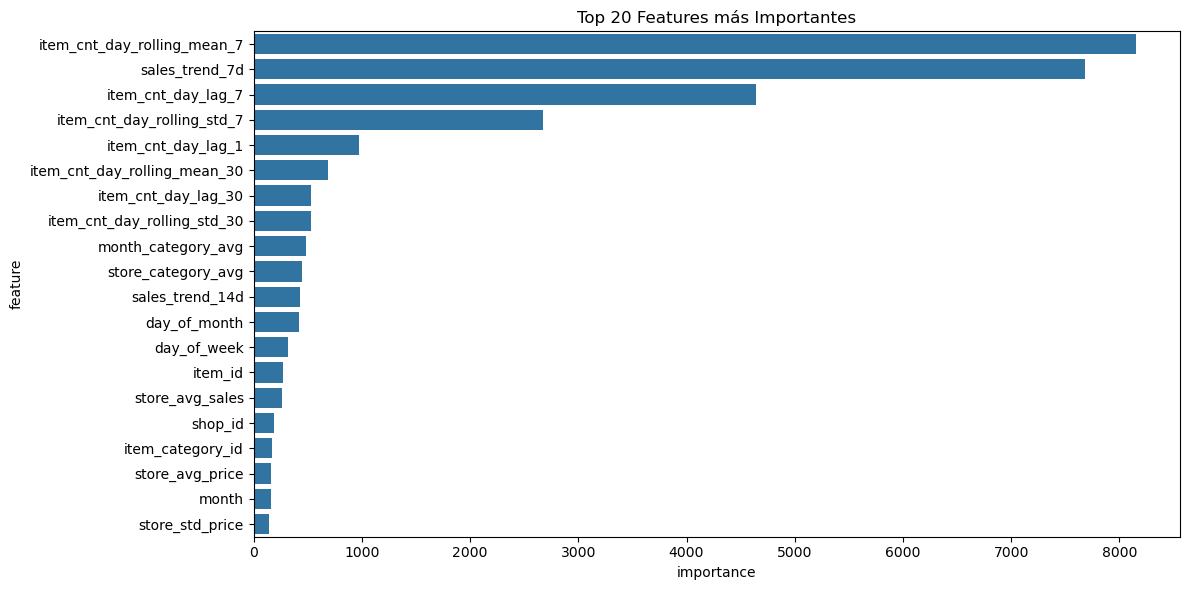

2025-02-18 22:50:13,649 - INFO - 
Top 20 features más importantes:
2025-02-18 22:50:13,649 - INFO - item_cnt_day_rolling_mean_7: 8152.0000
2025-02-18 22:50:13,649 - INFO - sales_trend_7d: 7679.0000
2025-02-18 22:50:13,650 - INFO - item_cnt_day_lag_7: 4639.0000
2025-02-18 22:50:13,650 - INFO - item_cnt_day_rolling_std_7: 2678.0000
2025-02-18 22:50:13,650 - INFO - item_cnt_day_lag_1: 976.0000
2025-02-18 22:50:13,650 - INFO - item_cnt_day_rolling_mean_30: 686.0000
2025-02-18 22:50:13,651 - INFO - item_cnt_day_lag_30: 533.0000
2025-02-18 22:50:13,651 - INFO - item_cnt_day_rolling_std_30: 530.0000
2025-02-18 22:50:13,651 - INFO - month_category_avg: 480.0000
2025-02-18 22:50:13,651 - INFO - store_category_avg: 443.0000
2025-02-18 22:50:13,652 - INFO - sales_trend_14d: 426.0000
2025-02-18 22:50:13,653 - INFO - day_of_month: 415.0000
2025-02-18 22:50:13,653 - INFO - day_of_week: 320.0000
2025-02-18 22:50:13,654 - INFO - item_id: 271.0000
2025-02-18 22:50:13,654 - INFO - store_avg_sales: 266.0

In [31]:
# 4. Modelo Mejorado v1 - Features Temporales Mejoradas

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class SalesPredictionV1:
    def __init__(self, data_path: Path):
        self.data_path = data_path
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.model = None
        self.version = "v1_temporal_features"
        
    def load_and_preprocess_test(self):
        """Carga y preprocesa los datos de prueba"""
        logger.info("Cargando y procesando datos de prueba...")
        
        # Cargar datos originales de test
        test = pd.read_csv(self.data_path / "test.csv")
        items = pd.read_csv(self.data_path / "items.csv")
        
        # Merge con información de categorías
        test = test.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
        
        # Agregar features temporales
        test['date'] = pd.to_datetime('2015-11-01')  # Mes de predicción
        test['month'] = test['date'].dt.month
        test['day_of_month'] = test['date'].dt.day
        test['day_of_week'] = test['date'].dt.dayofweek
        test['is_weekend'] = test['day_of_week'].isin([5, 6]).astype(int)
        
        # Features cíclicas
        test['month_sin'] = np.sin(2 * np.pi * test['month']/12)
        test['month_cos'] = np.cos(2 * np.pi * test['month']/12)
        
        logger.info(f"Datos de prueba procesados. Shape: {test.shape}")
        return test
    
    def load_data(self):
        """Carga datos de entrenamiento y prueba"""
        logger.info("Cargando datos...")
        
        # Cargar datos procesados de entrenamiento
        self.X_train = pd.read_csv(self.data_path / "processed/X_processed_enhanced.csv")
        y_df = pd.read_csv(self.data_path / "processed/y_processed.csv")
        self.y_train = y_df.iloc[:, 0]
        
        # Procesar y cargar datos de prueba
        self.X_test = self.load_and_preprocess_test()
        
        logger.info(f"Datos cargados - Shape: X_train={self.X_train.shape}, X_test={self.X_test.shape}")
    
    def prepare_test_features(self):
        """Prepara features avanzadas para el conjunto de prueba"""
        logger.info("Preparando features avanzadas para test...")
        try:
            # Obtener últimos datos de entrenamiento (octubre 2015)
            train_oct = self.X_train[self.X_train['month'] == 10].copy()
            
            # Preparar features de lag
            test_features = self.X_test.copy()
            test_ids = test_features['ID'].copy()
            
            # 1. Features Temporales Mejoradas
            logger.info("Creando features temporales mejoradas...")
            
            # Promedios por mes-item
            month_item_stats = train_oct.groupby(['month', 'item_id']).agg({
                'item_cnt_day_lag_1': ['mean', 'std', 'max']
            }).reset_index()
            month_item_stats.columns = ['month', 'item_id', 'month_item_avg', 'month_item_std', 'month_item_max']
            
            # Promedios por mes-tienda
            month_shop_stats = train_oct.groupby(['month', 'shop_id']).agg({
                'item_cnt_day_lag_1': ['mean', 'std', 'max']
            }).reset_index()
            month_shop_stats.columns = ['month', 'shop_id', 'month_shop_avg', 'month_shop_std', 'month_shop_max']
            
            # Promedios por mes-categoría
            month_cat_stats = train_oct.groupby(['month', 'item_category_id']).agg({
                'item_cnt_day_lag_1': ['mean', 'std', 'max']
            }).reset_index()
            month_cat_stats.columns = ['month', 'item_category_id', 'month_cat_avg', 'month_cat_std', 'month_cat_max']
            
            # Merge con test_features
            test_features = test_features.merge(month_item_stats, on=['month', 'item_id'], how='left').fillna(0)
            test_features = test_features.merge(month_shop_stats, on=['month', 'shop_id'], how='left').fillna(0)
            test_features = test_features.merge(month_cat_stats, on=['month', 'item_category_id'], how='left').fillna(0)
            
            # 2. Features de Tendencia Mejoradas
            logger.info("Creando features de tendencia mejoradas...")
            
            # Tendencias de ventas más largas
            for window in [7, 14, 30, 60, 90]:
                col_name = f'sales_trend_{window}d'
                test_features[col_name] = train_oct.groupby(['shop_id', 'item_id'])['item_cnt_day_lag_1'].transform(
                    lambda x: x.rolling(window, min_periods=1).mean()
                )
            
            # 3. Features de Interacción
            logger.info("Creando features de interacción...")
            
            # Interacciones tienda-categoría
            test_features['store_category_avg'] = test_features.groupby(['shop_id', 'item_category_id'])['month_shop_avg'].transform('mean')
            
            # Interacciones temporales
            test_features['month_category_avg'] = test_features.groupby(['month', 'item_category_id'])['month_cat_avg'].transform('mean')
            
            # 4. Features de Volatilidad
            logger.info("Creando features de volatilidad...")
            
            test_features['sales_volatility'] = test_features['month_item_std'] / (test_features['month_item_avg'] + 1)
            
            # Asegurar que tenemos todas las columnas necesarias
            missing_cols = set(self.X_train.columns) - set(test_features.columns)
            for col in missing_cols:
                test_features[col] = 0
                    
            # Reordenar columnas como en training
            test_features = test_features[self.X_train.columns]
            test_features['ID'] = test_ids
            
            logger.info(f"Features de test preparadas. Shape final: {test_features.shape}")
            self.X_test = test_features
            
        except Exception as e:
            logger.error(f"Error en preparación de features de test: {str(e)}")
            raise
    
    def train_final_model(self):
        """Entrena el modelo final"""
        logger.info("Entrenando modelo final...")
        
        self.model = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.05,
            num_leaves=31,
            random_state=42
        )
        
        self.model.fit(self.X_train, self.y_train)
        
        # Mostrar importancia de features
        importance = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        logger.info("\nTop 10 features más importantes:")
        for idx, row in importance.head(10).iterrows():
            logger.info(f"{row['feature']}: {row['importance']:.4f}")
    
    def analyze_features(self):
        """Analiza la importancia y distribución de las features"""
        logger.info("Analizando features...")
        
        # Importancia de features
        importance = pd.DataFrame({
            'feature': self.X_train.columns,
            'importance': self.model.feature_importances_
        }).sort_values('importance', ascending=False)
        
        # Top 20 features
        plt.figure(figsize=(12, 6))
        sns.barplot(data=importance.head(20), x='importance', y='feature')
        plt.title('Top 20 Features más Importantes')
        plt.tight_layout()
        plt.show()
        
        # Mostrar importancia numérica
        logger.info("\nTop 20 features más importantes:")
        for idx, row in importance.head(20).iterrows():
            logger.info(f"{row['feature']}: {row['importance']:.4f}")
            
        return importance
    
    def generate_predictions(self):
        """Genera predicciones para el conjunto de prueba"""
        logger.info("Generando predicciones...")
        try:
            # Obtener columnas para predicción (todas excepto ID)
            X_test_pred = self.X_test.drop('ID', axis=1)
            
            # Predecir
            predictions = self.model.predict(X_test_pred)
            
            # Crear submission
            submission = pd.DataFrame({
                'ID': self.X_test['ID'],
                'item_cnt_month': predictions.clip(0, 20)  # Clip predictions entre 0 y 20
            })
            
            # Crear directorio si no existe
            submission_dir = self.data_path / "submissions"
            submission_dir.mkdir(parents=True, exist_ok=True)
            
            # Guardar submission con versión
            submission_path = submission_dir / f"submission_{self.version}.csv"
            submission.to_csv(submission_path, index=False)
            logger.info(f"✅ Predicciones guardadas en: {submission_path}")
            
            return submission
            
        except Exception as e:
            logger.error(f"Error en generación de predicciones: {str(e)}")
            raise

# Ejecutar predicción
if __name__ == "__main__":
    try:
        data_path = Path("/Users/davidescudero/Documents/ITAM/PDT02/data")
        
        logger.info("Iniciando proceso de predicción con features mejoradas v1...")
        
        # Inicializar y ejecutar predicción
        predictor = SalesPredictionV1(data_path)
        
        # Cargar y procesar datos
        predictor.load_data()
        
        # Preparar features de test
        predictor.prepare_test_features()
        
        # Entrenar modelo final
        predictor.train_final_model()
        
        # Analizar features
        importance_df = predictor.analyze_features()
        
        # Generar predicciones
        submission = predictor.generate_predictions()
        
        logger.info("✅ Proceso de predicción v1 completado exitosamente!")
        
    except Exception as e:
        logger.error(f"❌ Error en el proceso: {str(e)}")
        raise

2025-02-18 23:01:04,358 - INFO - Iniciando análisis del modelo...


2025-02-18 23:01:04,398 - INFO - Cargando datos...
2025-02-18 23:01:09,314 - INFO - Cargando y procesando datos de prueba...
2025-02-18 23:01:09,421 - INFO - Datos de prueba procesados. Shape: (214200, 11)
2025-02-18 23:01:09,422 - INFO - Datos cargados - Shape: X_train=(2935849, 29), X_test=(214200, 11)
2025-02-18 23:01:09,423 - INFO - Preparando features avanzadas para test...
2025-02-18 23:01:09,490 - INFO - Creando features temporales mejoradas...
2025-02-18 23:01:09,597 - INFO - Creando features de tendencia mejoradas...
2025-02-18 23:01:41,928 - INFO - Creando features de interacción...
2025-02-18 23:01:41,944 - INFO - Creando features de volatilidad...
2025-02-18 23:01:41,965 - INFO - Features de test preparadas. Shape final: (214200, 30)
2025-02-18 23:01:41,969 - INFO - Entrenando modelo final...
2025-02-18 23:02:15,307 - INFO - 
Top 10 features más importantes:
2025-02-18 23:02:15,309 - INFO - item_cnt_day_rolling_mean_7: 8152.0000
2025-02-18 23:02:15,310 - INFO - sales_trend_


=== Información de Shapes ===
X_train shape: (2935849, 29)
y_train shape: (2935849,)
X_test shape: (214200, 30)

=== Valores Nulos en X_train ===
item_cnt_day_rolling_std_7     424124
item_cnt_day_rolling_std_30    424124
cat_std_sales                       2
cat_std_price                       2
price_volatility               130245
dtype: int64

=== Estadísticas de Variable Objetivo ===
count    2.935849e+06
mean     1.170137e+00
std      6.070654e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      5.000000e+00
Name: item_cnt_day, dtype: float64


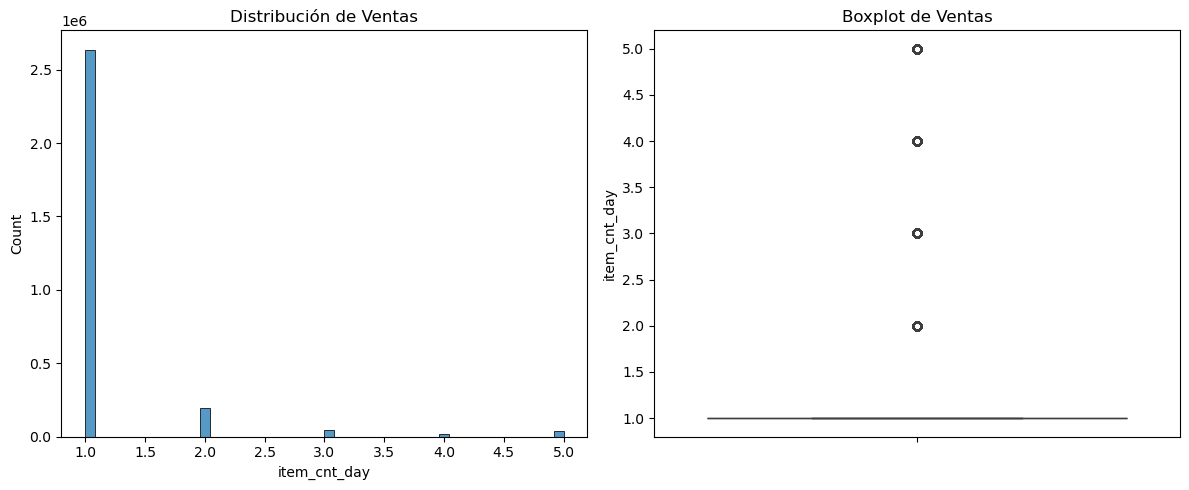

2025-02-18 23:02:18,972 - INFO - Analizando importancia de features...


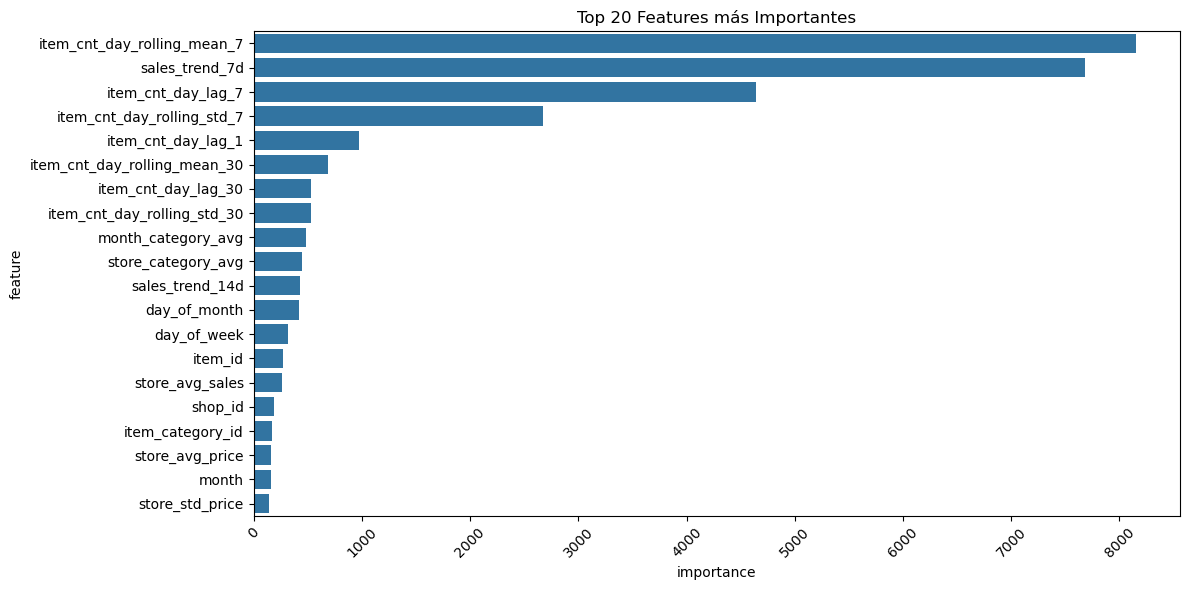

2025-02-18 23:02:19,107 - INFO - Analizando predicciones...


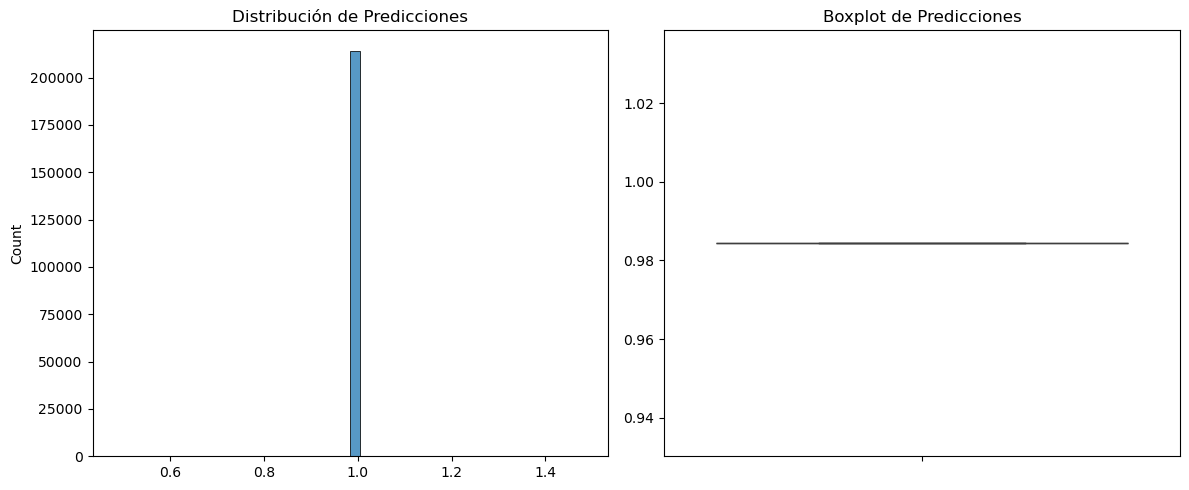

2025-02-18 23:02:20,600 - INFO - Realizando validación temporal...



=== Estadísticas de Predicciones ===
count    2.142000e+05
mean     9.843452e-01
std      1.110226e-16
min      9.843452e-01
25%      9.843452e-01
50%      9.843452e-01
75%      9.843452e-01
max      9.843452e-01
dtype: float64


2025-02-18 23:04:55,128 - INFO - Fold score: 0.07801
2025-02-18 23:07:36,471 - INFO - Fold score: 0.09691
2025-02-18 23:10:27,542 - INFO - Fold score: 0.07507
2025-02-18 23:10:27,545 - INFO - Media CV: 0.08333 ± 0.00968


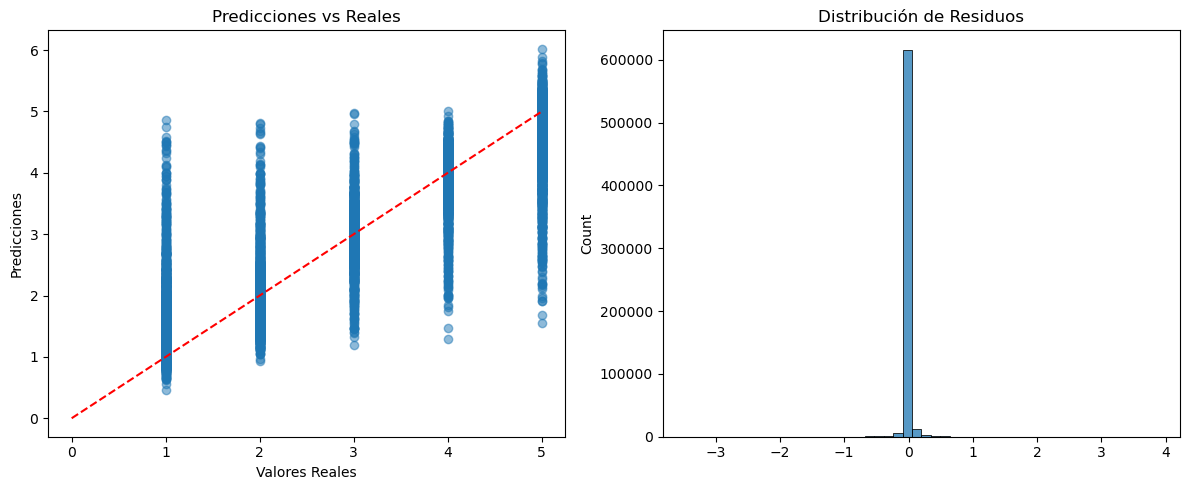

2025-02-18 23:10:29,814 - INFO - ✅ Análisis completado!


In [33]:
# 5. Análisis y Diagnóstico del Modelo

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import logging
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Configuración de logging y estilo de visualización
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def analyze_training_data(predictor):
    """Analiza los datos de entrenamiento"""
    logger.info("Analizando datos de entrenamiento...")
    
    # 1. Información básica
    print("\n=== Información de Shapes ===")
    print(f"X_train shape: {predictor.X_train.shape}")
    print(f"y_train shape: {predictor.y_train.shape}")
    print(f"X_test shape: {predictor.X_test.shape}")
    
    # 2. Análisis de valores nulos
    print("\n=== Valores Nulos en X_train ===")
    null_counts = predictor.X_train.isnull().sum()
    print(null_counts[null_counts > 0])
    
    # 3. Estadísticas básicas de y_train
    print("\n=== Estadísticas de Variable Objetivo ===")
    print(predictor.y_train.describe())
    
    # 4. Visualización de la distribución de y_train
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(predictor.y_train, bins=50)
    plt.title('Distribución de Ventas')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=predictor.y_train)
    plt.title('Boxplot de Ventas')
    
    plt.tight_layout()
    plt.show()
    
    return null_counts

def analyze_feature_importance(predictor):
    """Analiza la importancia de las features"""
    logger.info("Analizando importancia de features...")
    
    importance = pd.DataFrame({
        'feature': predictor.X_train.columns,
        'importance': predictor.model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Visualización
    plt.figure(figsize=(12, 6))
    sns.barplot(data=importance.head(20), x='importance', y='feature')
    plt.title('Top 20 Features más Importantes')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return importance

def analyze_predictions(predictor):
    """Analiza las predicciones del modelo"""
    logger.info("Analizando predicciones...")
    
    # Generar predicciones
    X_test_pred = predictor.X_test.drop('ID', axis=1)
    predictions = predictor.model.predict(X_test_pred)
    
    # Visualización
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(predictions, bins=50)
    plt.title('Distribución de Predicciones')
    
    plt.subplot(1, 2, 2)
    sns.boxplot(y=predictions)
    plt.title('Boxplot de Predicciones')
    
    plt.tight_layout()
    plt.show()
    
    # Estadísticas
    print("\n=== Estadísticas de Predicciones ===")
    print(pd.Series(predictions).describe())
    
    return predictions

def perform_temporal_validation(predictor):
    """Realiza validación temporal del modelo"""
    logger.info("Realizando validación temporal...")
    
    # Crear splits temporales
    tscv = TimeSeriesSplit(n_splits=3, test_size=len(predictor.X_test))
    
    scores = []
    predictions_val = []
    actuals_val = []
    
    for train_idx, val_idx in tscv.split(predictor.X_train):
        X_tr = predictor.X_train.iloc[train_idx]
        X_val = predictor.X_train.iloc[val_idx]
        y_tr = predictor.y_train.iloc[train_idx]
        y_val = predictor.y_train.iloc[val_idx]
        
        model = lgb.LGBMRegressor(
            n_estimators=3000,
            learning_rate=0.01,
            num_leaves=127,
            max_depth=12,
            min_child_samples=20,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42
        )
        
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        
        score = np.sqrt(mean_squared_error(y_val, preds))
        scores.append(score)
        
        predictions_val.extend(preds)
        actuals_val.extend(y_val)
        
        logger.info(f"Fold score: {score:.5f}")
    
    logger.info(f"Media CV: {np.mean(scores):.5f} ± {np.std(scores):.5f}")
    
    # Visualización de predicciones vs reales
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(actuals_val, predictions_val, alpha=0.5)
    plt.plot([0, max(actuals_val)], [0, max(actuals_val)], 'r--')
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.title('Predicciones vs Reales')
    
    plt.subplot(1, 2, 2)
    residuals = np.array(predictions_val) - np.array(actuals_val)
    sns.histplot(residuals, bins=50)
    plt.title('Distribución de Residuos')
    
    plt.tight_layout()
    plt.show()
    
    return scores, predictions_val, actuals_val

# Ejecutar análisis
if __name__ == "__main__":
    try:
        data_path = Path("/Users/davidescudero/Documents/ITAM/PDT02/data")
        
        logger.info("Iniciando análisis del modelo...")
        
        # Cargar modelo existente
        predictor = SalesPredictionV1(data_path)
        predictor.load_data()
        predictor.prepare_test_features()
        predictor.train_final_model()
        
        # 1. Análisis de datos de entrenamiento
        null_counts = analyze_training_data(predictor)
        
        # 2. Análisis de importancia de features
        importance_df = analyze_feature_importance(predictor)
        
        # 3. Análisis de predicciones
        predictions = analyze_predictions(predictor)
        
        # 4. Validación temporal
        scores, preds_val, actuals_val = perform_temporal_validation(predictor)
        
        logger.info("✅ Análisis completado!")
        
    except Exception as e:
        logger.error(f"❌ Error en el análisis: {str(e)}")
        raise

In [38]:
class DataProcessor:
    def __init__(self, data_path: Path):
        self.data_path = data_path
        self.version = datetime.now().strftime("%Y%m%d_%H%M")
        
    def process_data(self):
        """Procesamiento mejorado de datos"""
        logger.info("Iniciando procesamiento de datos...")
        
        try:
            # 1. Cargar datos
            sales = pd.read_csv(self.data_path / "sales_train.csv")
            items = pd.read_csv(self.data_path / "items.csv")
            
            # 2. Merge con información de items
            logger.info("Agregando información de items...")
            sales = sales.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
            
            # 3. Limpieza inicial
            logger.info("Limpiando datos...")
            sales = sales[sales['item_cnt_day'] >= 0]
            sales = sales[sales['item_cnt_day'] <= 100]  # Limitar outliers extremos
            sales = sales[sales['item_price'] > 0]
            
            # 4. Agregación mensual
            logger.info("Realizando agregación mensual...")
            monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
                'item_cnt_day': ['mean', 'sum', 'count'],
                'item_price': 'mean',
                'item_category_id': 'first'
            }).reset_index()
            
            # Renombrar columnas
            monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id', 
                                   'item_cnt_mean', 'item_cnt_sum', 'transaction_count',
                                   'item_price', 'item_category_id']
            
            # 5. Features mensuales
            logger.info("Creando features mensuales...")
            for lag in [1, 2, 3]:
                monthly_sales[f'sales_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_mean'].shift(lag)
                monthly_sales[f'sales_sum_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_sum'].shift(lag)
                monthly_sales[f'trans_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['transaction_count'].shift(lag)
            
            # 6. Media móvil
            for window in [2, 3]:
                monthly_sales[f'sales_ma_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_mean'].transform(
                    lambda x: x.rolling(window, min_periods=1).mean()
                )
            
            # 7. Features de categoría
            logger.info("Creando features de categoría...")
            monthly_sales['category_avg'] = monthly_sales.groupby(['date_block_num', 'item_category_id'])['item_cnt_mean'].transform('mean')
            monthly_sales['shop_avg'] = monthly_sales.groupby(['date_block_num', 'shop_id'])['item_cnt_mean'].transform('mean')
            
            # 8. Imputación de valores nulos
            fill_cols = [col for col in monthly_sales.columns if 'lag' in col or 'ma' in col]
            monthly_sales[fill_cols] = monthly_sales[fill_cols].fillna(0)
            
            # 9. Separar train/test
            train = monthly_sales[monthly_sales['date_block_num'] < 33]
            
            # 10. Crear directorio y guardar
            processed_dir = self.data_path / "processed" / f"processed_data_{self.version}"
            processed_dir.mkdir(parents=True, exist_ok=True)
            
            X = train.drop(['item_cnt_mean', 'item_cnt_sum'], axis=1)
            y = train['item_cnt_mean']
            
            X.to_csv(processed_dir / "X_train.csv", index=False)
            y.to_csv(processed_dir / "y_train.csv", index=False)
            
            logger.info(f"\nDatos procesados guardados en: {processed_dir}")
            logger.info(f"Shape final X: {X.shape}")
            logger.info("\nEstadísticas finales de variable objetivo:")
            print(y.describe())
            
            return X, y
            
        except Exception as e:
            logger.error(f"Error en procesamiento: {str(e)}")
            raise

2025-02-19 11:31:03,047 - INFO - Iniciando procesamiento de datos...
2025-02-19 11:31:03,859 - INFO - Agregando información de items...
2025-02-19 11:31:04,027 - INFO - Limpiando datos...
2025-02-19 11:31:04,254 - INFO - Realizando agregación mensual...
2025-02-19 11:31:04,738 - INFO - Creando features mensuales...
2025-02-19 11:31:56,914 - INFO - Creando features de categoría...
2025-02-19 11:32:06,382 - INFO - 
Datos procesados guardados en: /Users/davidescudero/Documents/ITAM/PDT02/data/processed/processed_data_20250219_1131
2025-02-19 11:32:06,383 - INFO - Shape final X: (1576699, 19)
2025-02-19 11:32:06,383 - INFO - 
Estadísticas finales de variable objetivo:
2025-02-19 11:32:06,473 - INFO - 
Análisis de features:
2025-02-19 11:32:06,474 - INFO - 
Distribución de la variable objetivo:


count    1.576699e+06
mean     1.071712e+00
std      5.541953e-01
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.800000e+01
Name: item_cnt_mean, dtype: float64


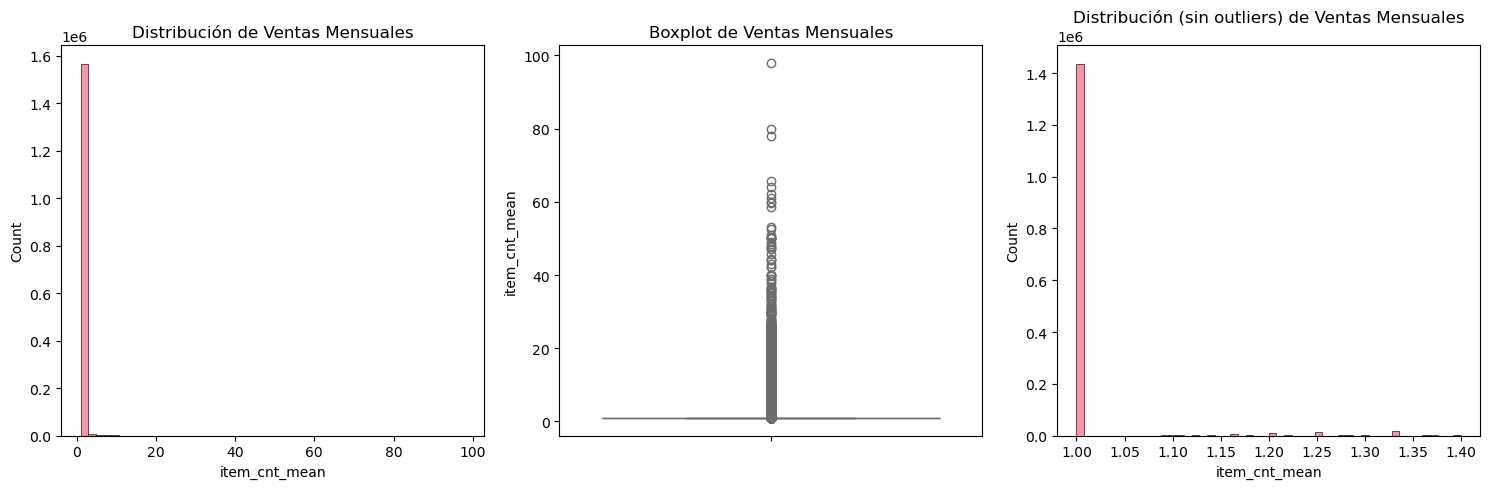

2025-02-19 11:32:08,867 - INFO - 
Top 10 correlaciones con variable objetivo:
2025-02-19 11:32:09,146 - INFO - 
No hay valores nulos en los datos procesados
2025-02-19 11:32:09,146 - INFO - 
Estadísticas de features principales:
2025-02-19 11:32:09,231 - INFO - ✅ Procesamiento y análisis completado exitosamente!


              feature  correlation
15        sales_ma_2m     0.893962
16        sales_ma_3m     0.852500
17       category_avg     0.390717
7    sales_sum_lag_1m     0.348919
10   sales_sum_lag_2m     0.300994
13   sales_sum_lag_3m     0.276145
3   transaction_count     0.274970
6        sales_lag_1m     0.154201
18           shop_avg     0.146902
8        trans_lag_1m     0.140733

sales_lag_1m:
count    1.576699e+06
mean     7.975899e-01
std      6.918517e-01
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      9.800000e+01
Name: sales_lag_1m, dtype: float64

sales_sum_lag_1m:
count    1.576699e+06
mean     1.899866e+00
std      7.451647e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.305000e+03
Name: sales_sum_lag_1m, dtype: float64

trans_lag_1m:
count    1.576699e+06
mean     1.498946e+00
std      2.106081e+00
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%     

In [39]:
import pandas as pd
import numpy as np
from pathlib import Path
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
sns.set_palette("husl")

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def plot_distributions(data, title):
    """Función auxiliar para visualizar distribuciones"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.histplot(data, bins=50)
    plt.title(f'Distribución de {title}')
    
    plt.subplot(1, 3, 2)
    sns.boxplot(y=data)
    plt.title(f'Boxplot de {title}')
    
    plt.subplot(1, 3, 3)
    sns.histplot(data[data <= np.percentile(data, 95)], bins=50)
    plt.title(f'Distribución (sin outliers) de {title}')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    try:
        data_path = Path("/Users/davidescudero/Documents/ITAM/PDT02/data")
        processor = DataProcessor(data_path)
        
        # Procesar datos
        X, y = processor.process_data()
        
        # Análisis de los datos procesados
        logger.info("\nAnálisis de features:")
        
        # 1. Visualizar distribución de la variable objetivo
        logger.info("\nDistribución de la variable objetivo:")
        plot_distributions(y, "Ventas Mensuales")
        
        # 2. Correlaciones
        logger.info("\nTop 10 correlaciones con variable objetivo:")
        correlations = pd.DataFrame({
            'feature': X.columns,
            'correlation': [X[col].corr(y) for col in X.columns]
        }).sort_values('correlation', ascending=False)
        print(correlations.head(10))
        
        # 3. Análisis de valores nulos
        null_counts = X.isnull().sum()
        if null_counts.sum() > 0:
            logger.info("\nColumnas con valores nulos:")
            print(null_counts[null_counts > 0])
        else:
            logger.info("\nNo hay valores nulos en los datos procesados")
        
        # 4. Estadísticas de las principales features
        logger.info("\nEstadísticas de features principales:")
        lag_cols = [col for col in X.columns if 'lag' in col]
        for col in lag_cols[:3]:  # Mostrar solo los primeros 3 lags
            print(f"\n{col}:")
            print(X[col].describe())
        
        logger.info("✅ Procesamiento y análisis completado exitosamente!")
        
    except Exception as e:
        logger.error(f"❌ Error en el proceso: {str(e)}")
        raise

In [40]:
class DataProcessor:
    def __init__(self, data_path: Path):
        self.data_path = data_path
        self.version = datetime.now().strftime("%Y%m%d_%H%M")
        
    def process_data(self):
        """Procesamiento mejorado de datos con transformaciones"""
        logger.info("Iniciando procesamiento de datos...")
        
        try:
            # 1. Cargar datos
            sales = pd.read_csv(self.data_path / "sales_train.csv")
            items = pd.read_csv(self.data_path / "items.csv")
            
            # 2. Merge con información de items
            logger.info("Agregando información de items...")
            sales = sales.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
            
            # 3. Limpieza y transformación inicial
            logger.info("Limpiando y transformando datos...")
            sales['item_cnt_day'] = sales['item_cnt_day'].clip(0, 20)  # Clip más agresivo
            sales = sales[sales['item_price'] > 0]
            
            # 4. Features de precio
            logger.info("Creando features de precio...")
            sales['price_normalized'] = sales.groupby('item_id')['item_price'].transform(
                lambda x: (x - x.mean()) / x.std()
            )
            
            # 5. Agregación mensual mejorada
            logger.info("Realizando agregación mensual...")
            monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
                'item_cnt_day': ['mean', 'sum', 'std'],  # Agregar desviación estándar
                'item_price': ['mean', 'std'],  # Agregar variabilidad de precio
                'price_normalized': 'mean',
                'item_category_id': 'first'
            }).reset_index()
            
            # Renombrar columnas
            monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id', 
                                   'item_cnt_mean', 'item_cnt_sum', 'item_cnt_std',
                                   'price_mean', 'price_std', 'price_norm',
                                   'item_category_id']
            
            # 6. Transformación logarítmica de ventas
            logger.info("Aplicando transformaciones...")
            monthly_sales['item_cnt_log'] = np.log1p(monthly_sales['item_cnt_mean'])
            
            # 7. Features mensuales y tendencias
            logger.info("Creando features temporales...")
            # Lags de diferentes métricas
            for lag in [1, 2, 3]:
                monthly_sales[f'sales_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].shift(lag)
                monthly_sales[f'sales_std_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_std'].shift(lag)
                monthly_sales[f'price_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['price_norm'].shift(lag)
            
            # Media móvil y tendencias
            for window in [2, 3, 6]:
                # Media móvil
                monthly_sales[f'sales_ma_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].transform(
                    lambda x: x.rolling(window, min_periods=1).mean()
                )
                
                # Tendencia
                monthly_sales[f'trend_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].transform(
                    lambda x: x.rolling(window, min_periods=2).apply(
                        lambda x: np.polyfit(np.arange(len(x)), x, 1)[0] if len(x) > 1 else 0
                    )
                )
            
            # 8. Features de categoría
            logger.info("Creando features de categoría...")
            monthly_sales['category_avg'] = monthly_sales.groupby(['date_block_num', 'item_category_id'])['item_cnt_log'].transform('mean')
            monthly_sales['shop_avg'] = monthly_sales.groupby(['date_block_num', 'shop_id'])['item_cnt_log'].transform('mean')
            
            # 9. Features de volatilidad
            monthly_sales['price_volatility'] = monthly_sales.groupby(['shop_id', 'item_id'])['price_norm'].transform('std')
            monthly_sales['sales_volatility'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].transform('std')
            
            # 10. Imputación de valores nulos
            fill_cols = [col for col in monthly_sales.columns if 'lag' in col or 'ma' in col or 'trend' in col]
            monthly_sales[fill_cols] = monthly_sales[fill_cols].fillna(0)
            
            # 11. Separar train/test
            train = monthly_sales[monthly_sales['date_block_num'] < 33]
            
            # 12. Crear directorio y guardar
            processed_dir = self.data_path / "processed" / f"processed_data_{self.version}"
            processed_dir.mkdir(parents=True, exist_ok=True)
            
            # Seleccionar features y target
            drop_cols = ['item_cnt_mean', 'item_cnt_sum', 'item_cnt_std']
            X = train.drop(drop_cols + ['item_cnt_log'], axis=1)
            y = train['item_cnt_log']
            
            X.to_csv(processed_dir / "X_train.csv", index=False)
            y.to_csv(processed_dir / "y_train.csv", index=False)
            
            logger.info(f"\nDatos procesados guardados en: {processed_dir}")
            logger.info(f"Shape final X: {X.shape}")
            logger.info("\nEstadísticas finales de variable objetivo (transformada):")
            print(y.describe())
            
            return X, y
            
        except Exception as e:
            logger.error(f"Error en procesamiento: {str(e)}")
            raise

2025-02-19 11:37:05,622 - INFO - Iniciando procesamiento de datos...
2025-02-19 11:37:06,419 - INFO - Agregando información de items...
2025-02-19 11:37:06,603 - INFO - Limpiando y transformando datos...
2025-02-19 11:37:06,702 - INFO - Creando features de precio...
2025-02-19 11:37:09,165 - INFO - Realizando agregación mensual...
2025-02-19 11:37:09,731 - INFO - Aplicando transformaciones...
2025-02-19 11:37:09,742 - INFO - Creando features temporales...
2025-02-19 11:42:16,475 - INFO - Creando features de categoría...
2025-02-19 11:42:37,638 - INFO - 
Datos procesados guardados en: /Users/davidescudero/Documents/ITAM/PDT02/data/processed/processed_data_20250219_1137
2025-02-19 11:42:37,640 - INFO - Shape final X: (1577593, 26)
2025-02-19 11:42:37,641 - INFO - 
Estadísticas finales de variable objetivo (transformada):
2025-02-19 11:42:37,745 - INFO - 
Análisis de features:
2025-02-19 11:42:37,746 - INFO - 
Distribución de la variable objetivo:


count    1.577593e+06
mean     7.168471e-01
std      1.129218e-01
min      0.000000e+00
25%      6.931472e-01
50%      6.931472e-01
75%      6.931472e-01
max      3.044522e+00
Name: item_cnt_log, dtype: float64


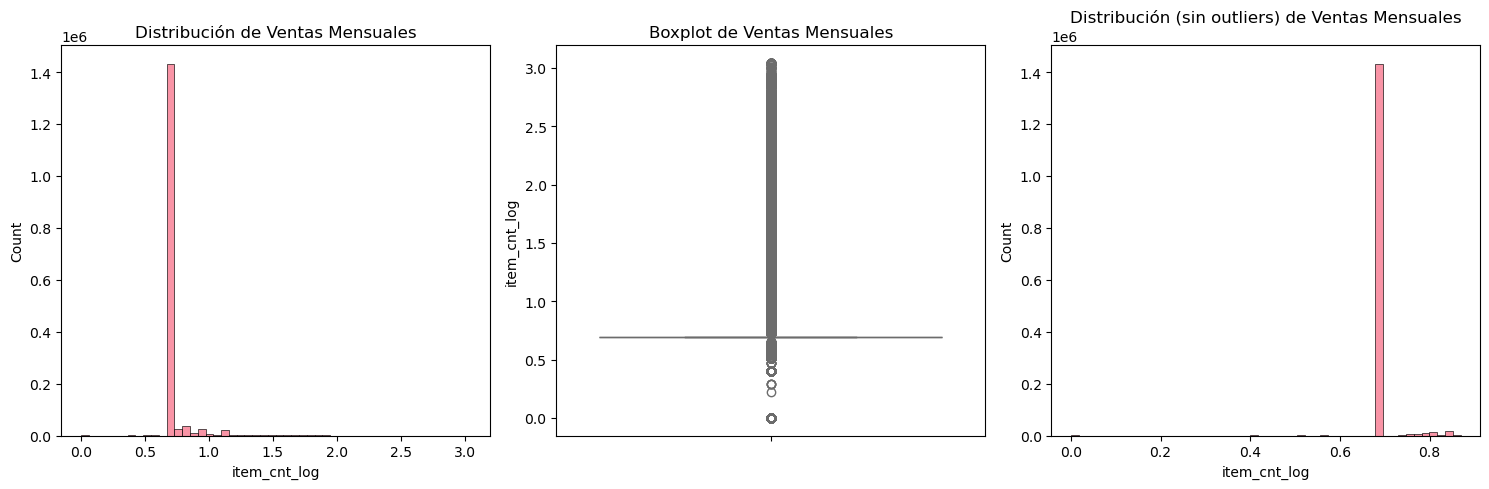

2025-02-19 11:42:40,152 - INFO - 
Top 10 correlaciones con variable objetivo:
2025-02-19 11:42:40,600 - INFO - 
Columnas con valores nulos:
2025-02-19 11:42:40,602 - INFO - 
Estadísticas de features principales:
2025-02-19 11:42:40,682 - INFO - ✅ Procesamiento y análisis completado exitosamente!


             feature  correlation
16       sales_ma_2m     0.887871
18       sales_ma_3m     0.843798
20       sales_ma_6m     0.802079
25  sales_volatility     0.449089
22      category_avg     0.385756
17          trend_2m     0.311111
8   sales_std_lag_1m     0.237647
19          trend_3m     0.226775
23          shop_avg     0.166485
11  sales_std_lag_2m     0.163836
price_std           1055076
price_norm            31979
price_volatility     159790
sales_volatility     139511
dtype: int64

sales_lag_1m:
count    1.577593e+06
mean     5.309160e-01
std      3.344592e-01
min      0.000000e+00
25%      0.000000e+00
50%      6.931472e-01
75%      6.931472e-01
max      3.044522e+00
Name: sales_lag_1m, dtype: float64

sales_std_lag_1m:
count    1.577593e+06
mean     6.554926e-02
std      3.605975e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.343503e+01
Name: sales_std_lag_1m, dtype: float64

price_lag_1m:
count    1.577593e+06
mean

In [41]:
import pandas as pd
import numpy as np
from pathlib import Path
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
sns.set_palette("husl")

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def plot_distributions(data, title):
    """Función auxiliar para visualizar distribuciones"""
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    sns.histplot(data, bins=50)
    plt.title(f'Distribución de {title}')
    
    plt.subplot(1, 3, 2)
    sns.boxplot(y=data)
    plt.title(f'Boxplot de {title}')
    
    plt.subplot(1, 3, 3)
    sns.histplot(data[data <= np.percentile(data, 95)], bins=50)
    plt.title(f'Distribución (sin outliers) de {title}')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    try:
        data_path = Path("/Users/davidescudero/Documents/ITAM/PDT02/data")
        processor = DataProcessor(data_path)
        
        # Procesar datos
        X, y = processor.process_data()
        
        # Análisis de los datos procesados
        logger.info("\nAnálisis de features:")
        
        # 1. Visualizar distribución de la variable objetivo
        logger.info("\nDistribución de la variable objetivo:")
        plot_distributions(y, "Ventas Mensuales")
        
        # 2. Correlaciones
        logger.info("\nTop 10 correlaciones con variable objetivo:")
        correlations = pd.DataFrame({
            'feature': X.columns,
            'correlation': [X[col].corr(y) for col in X.columns]
        }).sort_values('correlation', ascending=False)
        print(correlations.head(10))
        
        # 3. Análisis de valores nulos
        null_counts = X.isnull().sum()
        if null_counts.sum() > 0:
            logger.info("\nColumnas con valores nulos:")
            print(null_counts[null_counts > 0])
        else:
            logger.info("\nNo hay valores nulos en los datos procesados")
        
        # 4. Estadísticas de las principales features
        logger.info("\nEstadísticas de features principales:")
        lag_cols = [col for col in X.columns if 'lag' in col]
        for col in lag_cols[:3]:  # Mostrar solo los primeros 3 lags
            print(f"\n{col}:")
            print(X[col].describe())
        
        logger.info("✅ Procesamiento y análisis completado exitosamente!")
        
    except Exception as e:
        logger.error(f"❌ Error en el proceso: {str(e)}")
        raise

2025-02-19 11:49:52,730 - INFO - Iniciando procesamiento de datos...
2025-02-19 11:49:53,492 - INFO - Agregando información de items...
2025-02-19 11:49:53,677 - INFO - Limpiando datos...
2025-02-19 11:49:53,778 - INFO - Creando features de precio...
2025-02-19 11:49:56,519 - INFO - Realizando agregación mensual...
2025-02-19 11:49:57,130 - INFO - Aplicando transformaciones...
2025-02-19 11:49:57,154 - INFO - Creando features temporales...
2025-02-19 11:51:14,597 - INFO - Creando features de categoría...
2025-02-19 11:51:14,708 - INFO - 
Verificando valores nulos después del procesamiento:
2025-02-19 11:51:14,762 - INFO - No hay valores nulos en el dataset
2025-02-19 11:51:31,581 - INFO - 
Datos procesados guardados en: /Users/davidescudero/Documents/ITAM/PDT02/data/processed/processed_data_20250219_1149
2025-02-19 11:51:31,583 - INFO - Shape final X: (1577593, 22)
2025-02-19 11:51:31,584 - INFO - 
Estadísticas finales de variable objetivo (transformada):
2025-02-19 11:51:31,713 - INFO

count    1.577593e+06
mean     7.168471e-01
std      1.129218e-01
min      0.000000e+00
25%      6.931472e-01
50%      6.931472e-01
75%      6.931472e-01
max      3.044522e+00
Name: item_cnt_log, dtype: float64


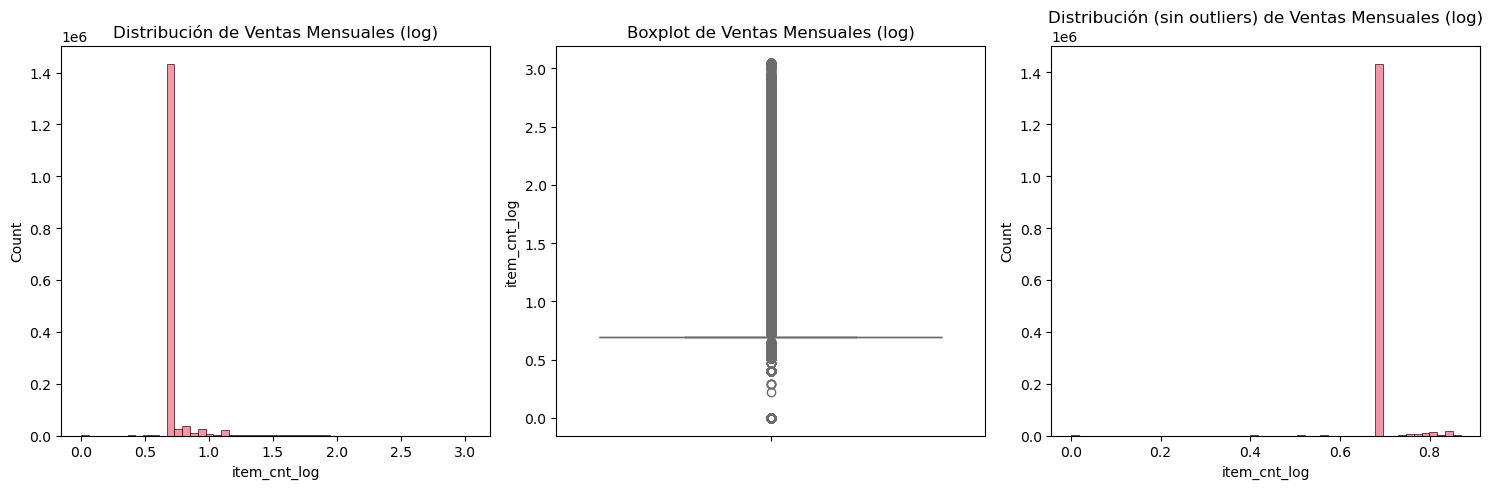

2025-02-19 11:51:34,091 - INFO - 
Top 10 correlaciones con variable objetivo:
2025-02-19 11:51:34,450 - INFO - ✅ Procesamiento y análisis completado exitosamente!


              feature  correlation
17        sales_ma_2m     0.887871
18        sales_ma_3m     0.843798
19        sales_ma_6m     0.802079
3   transaction_count     0.412415
20       category_avg     0.385756
21           shop_avg     0.166485
10  price_range_ratio     0.109275
9         price_range     0.094593
6           price_max     0.054969
4          price_mean     0.050490


In [42]:
import pandas as pd
import numpy as np
from pathlib import Path
import logging
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
sns.set_palette("husl")

# Configuración de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

class DataProcessor:
    def __init__(self, data_path: Path):
        self.data_path = data_path
        self.version = datetime.now().strftime("%Y%m%d_%H%M")
        
    def process_data(self):
        """Procesamiento mejorado de datos con manejo robusto de nulos"""
        logger.info("Iniciando procesamiento de datos...")
        
        try:
            # 1. Cargar datos
            sales = pd.read_csv(self.data_path / "sales_train.csv")
            items = pd.read_csv(self.data_path / "items.csv")
            
            # 2. Merge con información de items
            logger.info("Agregando información de items...")
            sales = sales.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
            
            # 3. Limpieza inicial
            logger.info("Limpiando datos...")
            sales['item_cnt_day'] = sales['item_cnt_day'].clip(0, 20)
            sales = sales[sales['item_price'] > 0]
            
            # 4. Features de precio con manejo seguro
            logger.info("Creando features de precio...")
            sales['price_normalized'] = sales.groupby('item_id')['item_price'].transform(
                lambda x: (x - x.mean()) / (x.std() if x.std() > 0 else 1)
            )
            
            # 5. Agregación mensual
            logger.info("Realizando agregación mensual...")
            monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
                'item_cnt_day': ['mean', 'sum', 'count'],
                'item_price': ['mean', 'min', 'max'],
                'price_normalized': 'mean',
                'item_category_id': 'first'
            }).reset_index()
            
            # Renombrar columnas
            monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id', 
                                   'item_cnt_mean', 'item_cnt_sum', 'transaction_count',
                                   'price_mean', 'price_min', 'price_max',
                                   'price_norm', 'item_category_id']
            
            # 6. Transformación logarítmica
            logger.info("Aplicando transformaciones...")
            monthly_sales['item_cnt_log'] = np.log1p(monthly_sales['item_cnt_mean'])
            
            # 7. Features de precio
            monthly_sales['price_range'] = monthly_sales['price_max'] - monthly_sales['price_min']
            monthly_sales['price_range_ratio'] = np.where(
                monthly_sales['price_mean'] > 0,
                monthly_sales['price_range'] / monthly_sales['price_mean'],
                0
            )
            
            # 8. Features temporales
            logger.info("Creando features temporales...")
            for lag in [1, 2, 3]:
                monthly_sales[f'sales_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].shift(lag).fillna(0)
                monthly_sales[f'price_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['price_norm'].shift(lag).fillna(0)
            
            # Media móvil
            for window in [2, 3, 6]:
                monthly_sales[f'sales_ma_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].transform(
                    lambda x: x.rolling(window, min_periods=1).mean()
                ).fillna(0)
            
            # 9. Features de categoría
            logger.info("Creando features de categoría...")
            monthly_sales['category_avg'] = monthly_sales.groupby(['date_block_num', 'item_category_id'])['item_cnt_log'].transform('mean')
            monthly_sales['shop_avg'] = monthly_sales.groupby(['date_block_num', 'shop_id'])['item_cnt_log'].transform('mean')
            
            # 10. Verificación de nulos
            logger.info("\nVerificando valores nulos después del procesamiento:")
            null_check = monthly_sales.isnull().sum()
            if null_check.sum() > 0:
                logger.warning("Se encontraron valores nulos:")
                print(null_check[null_check > 0])
            else:
                logger.info("No hay valores nulos en el dataset")
            
            # 11. Separar train/test
            train = monthly_sales[monthly_sales['date_block_num'] < 33]
            
            # 12. Crear directorio y guardar
            processed_dir = self.data_path / "processed" / f"processed_data_{self.version}"
            processed_dir.mkdir(parents=True, exist_ok=True)
            
            # Seleccionar features y target
            drop_cols = ['item_cnt_mean', 'item_cnt_sum']
            X = train.drop(drop_cols + ['item_cnt_log'], axis=1)
            y = train['item_cnt_log']
            
            X.to_csv(processed_dir / "X_train.csv", index=False)
            y.to_csv(processed_dir / "y_train.csv", index=False)
            
            logger.info(f"\nDatos procesados guardados en: {processed_dir}")
            logger.info(f"Shape final X: {X.shape}")
            logger.info("\nEstadísticas finales de variable objetivo (transformada):")
            print(y.describe())
            
            return X, y
            
        except Exception as e:
            logger.error(f"Error en procesamiento: {str(e)}")
            raise

if __name__ == "__main__":
    try:
        data_path = Path("/Users/davidescudero/Documents/ITAM/PDT02/data")
        processor = DataProcessor(data_path)
        X, y = processor.process_data()
        
        # Análisis de los datos procesados
        logger.info("\nAnálisis de features:")
        
        # 1. Visualizar distribución de la variable objetivo
        logger.info("\nDistribución de la variable objetivo:")
        plot_distributions(y, "Ventas Mensuales (log)")
        
        # 2. Correlaciones
        logger.info("\nTop 10 correlaciones con variable objetivo:")
        correlations = pd.DataFrame({
            'feature': X.columns,
            'correlation': [X[col].corr(y) for col in X.columns]
        }).sort_values('correlation', ascending=False)
        print(correlations.head(10))
        
        logger.info("✅ Procesamiento y análisis completado exitosamente!")
        
    except Exception as e:
        logger.error(f"❌ Error en el proceso: {str(e)}")
        raise

In [43]:
class DataProcessor:
    def __init__(self, data_path: Path):
        self.data_path = data_path
        self.version = datetime.now().strftime("%Y%m%d_%H%M")
        
    def process_data(self):
        """Procesamiento mejorado de datos con features adicionales"""
        logger.info("Iniciando procesamiento de datos...")
        
        try:
            # 1. Cargar datos
            sales = pd.read_csv(self.data_path / "sales_train.csv")
            items = pd.read_csv(self.data_path / "items.csv")
            
            # 2. Merge con información de items
            logger.info("Agregando información de items...")
            sales = sales.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
            
            # 3. Limpieza inicial
            logger.info("Limpiando datos...")
            sales['item_cnt_day'] = sales['item_cnt_day'].clip(0, 20)
            sales = sales[sales['item_price'] > 0]
            
            # 4. Features de precio con manejo seguro
            logger.info("Creando features de precio...")
            sales['price_normalized'] = sales.groupby('item_id')['item_price'].transform(
                lambda x: (x - x.mean()) / (x.std() if x.std() > 0 else 1)
            )
            
            # 5. Agregación mensual
            logger.info("Realizando agregación mensual...")
            monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
                'item_cnt_day': ['mean', 'sum', 'count'],
                'item_price': ['mean', 'min', 'max'],
                'price_normalized': 'mean',
                'item_category_id': 'first'
            }).reset_index()
            
            # Renombrar columnas
            monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id', 
                                   'item_cnt_mean', 'item_cnt_sum', 'transaction_count',
                                   'price_mean', 'price_min', 'price_max',
                                   'price_norm', 'item_category_id']
            
            # 6. Transformación logarítmica
            logger.info("Aplicando transformaciones...")
            monthly_sales['item_cnt_log'] = np.log1p(monthly_sales['item_cnt_mean'])
            
            # 7. Features de precio
            monthly_sales['price_range'] = monthly_sales['price_max'] - monthly_sales['price_min']
            monthly_sales['price_range_ratio'] = np.where(
                monthly_sales['price_mean'] > 0,
                monthly_sales['price_range'] / monthly_sales['price_mean'],
                0
            )
            
            # 8. Features temporales
            logger.info("Creando features temporales...")
            for lag in [1, 2, 3]:
                monthly_sales[f'sales_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].shift(lag).fillna(0)
                monthly_sales[f'price_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['price_norm'].shift(lag).fillna(0)
            
            # Media móvil
            for window in [2, 3, 6]:
                monthly_sales[f'sales_ma_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].transform(
                    lambda x: x.rolling(window, min_periods=1).mean()
                ).fillna(0)
            
            # 9. Features de tendencia
            logger.info("Creando features de tendencia...")
            for window in [2, 3, 6]:
                # Tendencia lineal
                monthly_sales[f'trend_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].transform(
                    lambda x: x.rolling(window, min_periods=2).apply(
                        lambda x: np.polyfit(np.arange(len(x)), x, 1)[0] if len(x) > 1 else 0
                    )
                ).fillna(0)
                
                # Aceleración (cambio en la tendencia)
                monthly_sales[f'trend_change_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])[f'trend_{window}m'].diff().fillna(0)
            
            # 10. Features estacionales
            logger.info("Creando features estacionales...")
            monthly_sales['month'] = monthly_sales['date_block_num'] % 12
            for month in range(12):
                monthly_sales[f'month_{month}'] = (monthly_sales['month'] == month).astype(int)
            
            # 11. Features de categoría
            logger.info("Creando features de categoría...")
            monthly_sales['category_avg'] = monthly_sales.groupby(['date_block_num', 'item_category_id'])['item_cnt_log'].transform('mean')
            monthly_sales['shop_avg'] = monthly_sales.groupby(['date_block_num', 'shop_id'])['item_cnt_log'].transform('mean')
            
            # 12. Features de interacción
            logger.info("Creando features de interacción...")
            monthly_sales['price_sales_ratio'] = monthly_sales['price_mean'] / monthly_sales['item_cnt_mean'].clip(lower=1)
            monthly_sales['category_shop_interaction'] = monthly_sales['category_avg'] * monthly_sales['shop_avg']
            monthly_sales['trend_price_interaction'] = monthly_sales['trend_3m'] * monthly_sales['price_range_ratio']
            
            # 13. Verificación de nulos
            logger.info("\nVerificando valores nulos después del procesamiento:")
            null_check = monthly_sales.isnull().sum()
            if null_check.sum() > 0:
                logger.warning("Se encontraron valores nulos:")
                print(null_check[null_check > 0])
            else:
                logger.info("No hay valores nulos en el dataset")
            
            # 14. Separar train/test
            train = monthly_sales[monthly_sales['date_block_num'] < 33]
            
            # 15. Crear directorio y guardar
            processed_dir = self.data_path / "processed" / f"processed_data_{self.version}"
            processed_dir.mkdir(parents=True, exist_ok=True)
            
            # Seleccionar features y target
            drop_cols = ['item_cnt_mean', 'item_cnt_sum', 'month']
            X = train.drop(drop_cols + ['item_cnt_log'], axis=1)
            y = train['item_cnt_log']
            
            X.to_csv(processed_dir / "X_train.csv", index=False)
            y.to_csv(processed_dir / "y_train.csv", index=False)
            
            logger.info(f"\nDatos procesados guardados en: {processed_dir}")
            logger.info(f"Shape final X: {X.shape}")
            logger.info("\nEstadísticas finales de variable objetivo (transformada):")
            print(y.describe())
            
            return X, y
            
        except Exception as e:
            logger.error(f"Error en procesamiento: {str(e)}")
            raise

2025-02-19 12:01:47,317 - INFO - Iniciando procesamiento de datos...
2025-02-19 12:01:48,182 - INFO - Agregando información de items...
2025-02-19 12:01:48,378 - INFO - Limpiando datos...
2025-02-19 12:01:48,516 - INFO - Creando features de precio...
2025-02-19 12:01:51,128 - INFO - Realizando agregación mensual...
2025-02-19 12:01:51,613 - INFO - Aplicando transformaciones...
2025-02-19 12:01:51,635 - INFO - Creando features temporales...
2025-02-19 12:03:10,048 - INFO - Creando features de tendencia...
2025-02-19 12:07:00,784 - INFO - Creando features estacionales...
2025-02-19 12:07:00,840 - INFO - Creando features de categoría...
2025-02-19 12:07:00,936 - INFO - Creando features de interacción...
2025-02-19 12:07:00,956 - INFO - 
Verificando valores nulos después del procesamiento:
2025-02-19 12:07:01,035 - INFO - No hay valores nulos en el dataset
2025-02-19 12:07:27,661 - INFO - 
Datos procesados guardados en: /Users/davidescudero/Documents/ITAM/PDT02/data/processed/processed_dat

count    1.577593e+06
mean     7.168471e-01
std      1.129218e-01
min      0.000000e+00
25%      6.931472e-01
50%      6.931472e-01
75%      6.931472e-01
max      3.044522e+00
Name: item_cnt_log, dtype: float64


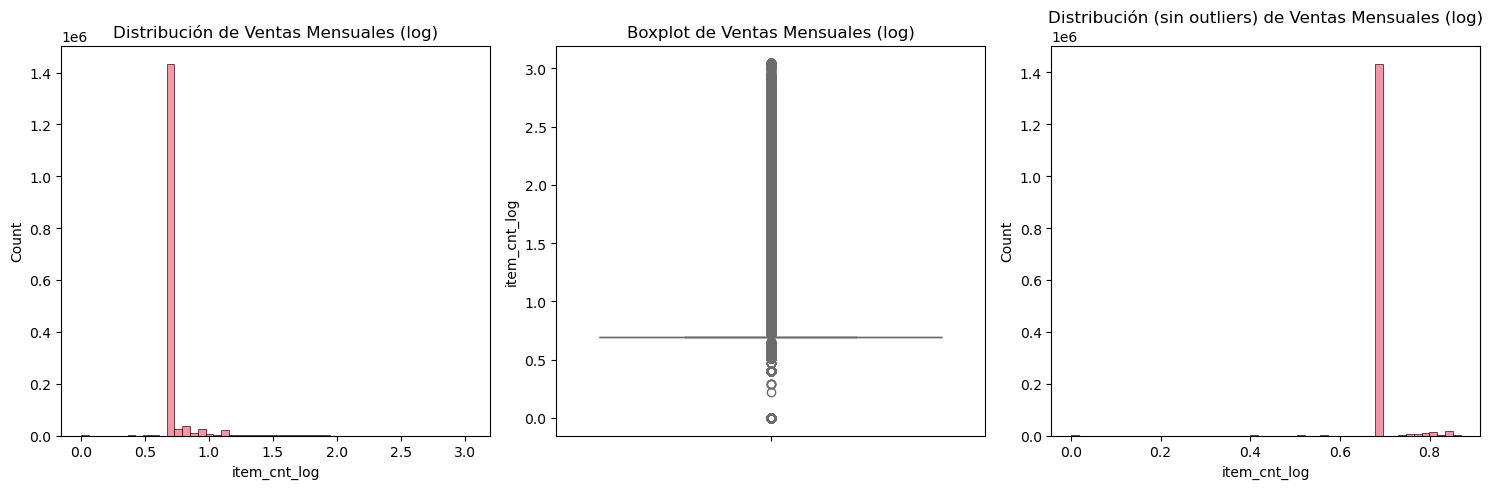

2025-02-19 12:07:30,304 - INFO - 
Top 15 correlaciones con variable objetivo:
2025-02-19 12:07:30,918 - INFO - 
Estadísticas de features de tendencia:
2025-02-19 12:07:31,092 - INFO - 
Distribución por mes:
2025-02-19 12:07:31,110 - INFO - 
Estadísticas de features de interacción:


                      feature  correlation
17                sales_ma_2m     0.887871
18                sales_ma_3m     0.843798
19                sales_ma_6m     0.802079
3           transaction_count     0.412415
41  category_shop_interaction     0.404602
38               category_avg     0.385756
20                   trend_2m     0.311111
22                   trend_3m     0.226775
21            trend_change_2m     0.197753
23            trend_change_3m     0.196762
39                   shop_avg     0.166485
25            trend_change_6m     0.143342
24                   trend_6m     0.137667
10          price_range_ratio     0.109275
9                 price_range     0.094593

trend_2m:
count    1.577593e+06
mean    -6.633726e-03
std      1.052829e-01
min     -3.044522e+00
25%     -7.761697e-17
50%     -7.761697e-17
75%      0.000000e+00
max      2.351375e+00
Name: trend_2m, dtype: float64

trend_change_2m:
count    1.577593e+06
mean    -8.725273e-04
std      1.614230e-01
min     -5

2025-02-19 12:07:31,189 - INFO - ✅ Procesamiento y análisis completado exitosamente!


count    1.577593e+06
mean     7.493421e+02
std      1.458585e+03
min      1.666667e-02
25%      1.990000e+02
50%      3.490000e+02
75%      7.990000e+02
max      3.079800e+05
Name: price_sales_ratio, dtype: float64

category_shop_interaction:
count    1.577593e+06
mean     5.139497e-01
std      3.600748e-02
min      0.000000e+00
25%      4.997033e-01
50%      5.065239e-01
75%      5.187725e-01
max      2.216121e+00
Name: category_shop_interaction, dtype: float64

trend_price_interaction:
count    1.577593e+06
mean     1.458203e-05
std      1.579593e-02
min     -1.877265e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      3.381262e+00
Name: trend_price_interaction, dtype: float64


In [44]:
if __name__ == "__main__":
    try:
        data_path = Path("/Users/davidescudero/Documents/ITAM/PDT02/data")
        processor = DataProcessor(data_path)
        X, y = processor.process_data()
        
        # Análisis detallado de los datos procesados
        logger.info("\nAnálisis de features:")
        
        # 1. Visualizar distribución de la variable objetivo
        logger.info("\nDistribución de la variable objetivo:")
        plot_distributions(y, "Ventas Mensuales (log)")
        
        # 2. Correlaciones
        logger.info("\nTop 15 correlaciones con variable objetivo:")
        correlations = pd.DataFrame({
            'feature': X.columns,
            'correlation': [X[col].corr(y) for col in X.columns]
        }).sort_values('correlation', ascending=False)
        print(correlations.head(15))
        
        # 3. Análisis de features de tendencia
        logger.info("\nEstadísticas de features de tendencia:")
        trend_cols = [col for col in X.columns if 'trend' in col]
        for col in trend_cols:
            print(f"\n{col}:")
            print(X[col].describe())
        
        # 4. Análisis de features estacionales
        logger.info("\nDistribución por mes:")
        month_cols = [col for col in X.columns if 'month_' in col]
        monthly_means = pd.DataFrame({
            'month': range(12),
            'mean_sales': [y[X[f'month_{i}'] == 1].mean() for i in range(12)]
        })
        print(monthly_means.sort_values('mean_sales', ascending=False))
        
        # 5. Análisis de features de interacción
        logger.info("\nEstadísticas de features de interacción:")
        interaction_cols = ['price_sales_ratio', 'category_shop_interaction', 'trend_price_interaction']
        for col in interaction_cols:
            print(f"\n{col}:")
            print(X[col].describe())
        
        logger.info("✅ Procesamiento y análisis completado exitosamente!")
        
    except Exception as e:
        logger.error(f"❌ Error en el proceso: {str(e)}")
        raise

In [45]:
class DataProcessor:
    def __init__(self, data_path: Path):
        self.data_path = data_path
        self.version = datetime.now().strftime("%Y%m%d_%H%M")
        
    def process_data(self):
        """Procesamiento mejorado de datos con features adicionales"""
        logger.info("Iniciando procesamiento de datos...")
        
        try:
            # 1. Cargar datos
            sales = pd.read_csv(self.data_path / "sales_train.csv")
            items = pd.read_csv(self.data_path / "items.csv")
            
            # 2. Merge con información de items
            logger.info("Agregando información de items...")
            sales = sales.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
            
            # 3. Limpieza inicial
            logger.info("Limpiando datos...")
            sales['item_cnt_day'] = sales['item_cnt_day'].clip(0, 20)
            sales = sales[sales['item_price'] > 0]
            
            # 4. Features de precio con manejo seguro
            logger.info("Creando features de precio...")
            sales['price_normalized'] = sales.groupby('item_id')['item_price'].transform(
                lambda x: (x - x.mean()) / (x.std() if x.std() > 0 else 1)
            )
            
            # 5. Agregación mensual
            logger.info("Realizando agregación mensual...")
            monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
                'item_cnt_day': ['mean', 'sum', 'count'],
                'item_price': ['mean', 'min', 'max'],
                'price_normalized': 'mean',
                'item_category_id': 'first'
            }).reset_index()
            
            # Renombrar columnas
            monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id', 
                                   'item_cnt_mean', 'item_cnt_sum', 'transaction_count',
                                   'price_mean', 'price_min', 'price_max',
                                   'price_norm', 'item_category_id']
            
            # 6. Transformación logarítmica
            logger.info("Aplicando transformaciones...")
            monthly_sales['item_cnt_log'] = np.log1p(monthly_sales['item_cnt_mean'])
            
            # 7. Features de precio
            monthly_sales['price_range'] = monthly_sales['price_max'] - monthly_sales['price_min']
            monthly_sales['price_range_ratio'] = np.where(
                monthly_sales['price_mean'] > 0,
                monthly_sales['price_range'] / monthly_sales['price_mean'],
                0
            )
            
            # 8. Features temporales mejorados
            logger.info("Creando features temporales...")
            # Lags
            for lag in [1, 2, 3]:
                monthly_sales[f'sales_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].shift(lag).fillna(0)
                monthly_sales[f'price_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['price_norm'].shift(lag).fillna(0)
            
            # Media móvil
            for window in [2, 3, 6]:
                monthly_sales[f'sales_ma_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].transform(
                    lambda x: x.rolling(window, min_periods=1).mean()
                ).fillna(0)
            
            # Velocidad de cambio
            monthly_sales['sales_velocity'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].diff().fillna(0)
            monthly_sales['price_velocity'] = monthly_sales.groupby(['shop_id', 'item_id'])['price_norm'].diff().fillna(0)
            
            # 9. Features de tendencia
            logger.info("Creando features de tendencia...")
            for window in [2, 3, 6]:
                # Tendencia lineal
                monthly_sales[f'trend_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].transform(
                    lambda x: x.rolling(window, min_periods=2).apply(
                        lambda x: np.polyfit(np.arange(len(x)), x, 1)[0] if len(x) > 1 else 0
                    )
                ).fillna(0)
                
                # Aceleración (cambio en la tendencia)
                monthly_sales[f'trend_change_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])[f'trend_{window}m'].diff().fillna(0)
            
            # 10. Features estacionales mejorados
            logger.info("Creando features estacionales...")
            monthly_sales['month'] = monthly_sales['date_block_num'] % 12
            monthly_sales['season'] = (monthly_sales['month'] // 3).astype(int)
            
            # Indicadores mensuales y estacionales
            for month in range(12):
                monthly_sales[f'month_{month}'] = (monthly_sales['month'] == month).astype(int)
            
            for season in range(4):
                monthly_sales[f'season_{season}'] = (monthly_sales['season'] == season).astype(int)
            
            # 11. Features de categoría
            logger.info("Creando features de categoría...")
            monthly_sales['category_avg'] = monthly_sales.groupby(['date_block_num', 'item_category_id'])['item_cnt_log'].transform('mean')
            monthly_sales['shop_avg'] = monthly_sales.groupby(['date_block_num', 'shop_id'])['item_cnt_log'].transform('mean')
            
            # 12. Features de interacción mejorados
            logger.info("Creando features de interacción...")
            monthly_sales['price_sales_ratio'] = monthly_sales['price_mean'] / monthly_sales['item_cnt_mean'].clip(lower=1)
            monthly_sales['category_shop_interaction'] = monthly_sales['category_avg'] * monthly_sales['shop_avg']
            monthly_sales['trend_price_interaction'] = monthly_sales['trend_3m'] * monthly_sales['price_range_ratio']
            
            # Nuevas interacciones
            monthly_sales['trend_season_interaction'] = monthly_sales['trend_3m'] * monthly_sales[f'season_{monthly_sales["season"]}']
            monthly_sales['price_season_interaction'] = monthly_sales['price_range_ratio'] * monthly_sales[f'season_{monthly_sales["season"]}']
            monthly_sales['velocity_price_interaction'] = monthly_sales['sales_velocity'] * monthly_sales['price_velocity']
            
            # 13. Verificación de nulos
            logger.info("\nVerificando valores nulos después del procesamiento:")
            null_check = monthly_sales.isnull().sum()
            if null_check.sum() > 0:
                logger.warning("Se encontraron valores nulos:")
                print(null_check[null_check > 0])
            else:
                logger.info("No hay valores nulos en el dataset")
            
            # 14. Separar train/test
            train = monthly_sales[monthly_sales['date_block_num'] < 33]
            
            # 15. Crear directorio y guardar
            processed_dir = self.data_path / "processed" / f"processed_data_{self.version}"
            processed_dir.mkdir(parents=True, exist_ok=True)
            
            # Seleccionar features y target
            drop_cols = ['item_cnt_mean', 'item_cnt_sum', 'month', 'season']
            X = train.drop(drop_cols + ['item_cnt_log'], axis=1)
            y = train['item_cnt_log']
            
            X.to_csv(processed_dir / "X_train.csv", index=False)
            y.to_csv(processed_dir / "y_train.csv", index=False)
            
            logger.info(f"\nDatos procesados guardados en: {processed_dir}")
            logger.info(f"Shape final X: {X.shape}")
            logger.info("\nEstadísticas finales de variable objetivo (transformada):")
            print(y.describe())
            
            return X, y
            
        except Exception as e:
            logger.error(f"Error en procesamiento: {str(e)}")
            raise

In [46]:
if __name__ == "__main__":
    try:
        data_path = Path("/Users/davidescudero/Documents/ITAM/PDT02/data")
        processor = DataProcessor(data_path)
        X, y = processor.process_data()
        
        # Análisis detallado de los datos procesados
        logger.info("\nAnálisis detallado de features:")
        
        # 1. Correlaciones por grupos de features
        feature_groups = {
            'Temporales': [col for col in X.columns if any(x in col for x in ['lag', 'ma'])],
            'Tendencia': [col for col in X.columns if 'trend' in col],
            'Estacionales': [col for col in X.columns if any(x in col for x in ['month_', 'season_'])],
            'Precio': [col for col in X.columns if 'price' in col],
            'Velocidad': [col for col in X.columns if 'velocity' in col],
            'Interacciones': [col for col in X.columns if 'interaction' in col]
        }
        
        logger.info("\nCorrelaciones por grupo de features:")
        for group_name, features in feature_groups.items():
            correlations = pd.DataFrame({
                'feature': features,
                'correlation': [X[col].corr(y) for col in features]
            }).sort_values('correlation', ascending=False)
            
            print(f"\n{group_name}:")
            print(correlations.head(5))
        
        # 2. Análisis de estacionalidad
        logger.info("\nAnálisis estacional:")
        
        # Por mes
        monthly_stats = pd.DataFrame({
            'month': range(12),
            'mean_sales': [y[X[f'month_{i}'] == 1].mean() for i in range(12)],
            'std_sales': [y[X[f'month_{i}'] == 1].std() for i in range(12)]
        })
        print("\nEstadísticas mensuales:")
        print(monthly_stats.sort_values('mean_sales', ascending=False))
        
        # Por temporada
        season_stats = pd.DataFrame({
            'season': range(4),
            'mean_sales': [y[X[f'season_{i}'] == 1].mean() for i in range(4)],
            'std_sales': [y[X[f'season_{i}'] == 1].std() for i in range(4)]
        })
        print("\nEstadísticas por temporada:")
        print(season_stats.sort_values('mean_sales', ascending=False))
        
        # 3. Análisis de velocidad y aceleración
        logger.info("\nEstadísticas de velocidad y aceleración:")
        velocity_cols = ['sales_velocity', 'price_velocity', 'velocity_price_interaction']
        for col in velocity_cols:
            print(f"\n{col}:")
            print(X[col].describe())
        
        # 4. Análisis de interacciones
        logger.info("\nEstadísticas de interacciones:")
        interaction_cols = [col for col in X.columns if 'interaction' in col]
        for col in interaction_cols:
            print(f"\n{col}:")
            print(X[col].describe())
            print(f"Correlación con target: {X[col].corr(y):.4f}")
        
        logger.info("✅ Procesamiento y análisis completado exitosamente!")
        
    except Exception as e:
        logger.error(f"❌ Error en el proceso: {str(e)}")
        raise

2025-02-19 12:27:48,140 - INFO - Iniciando procesamiento de datos...
2025-02-19 12:27:48,878 - INFO - Agregando información de items...
2025-02-19 12:27:49,056 - INFO - Limpiando datos...
2025-02-19 12:27:49,156 - INFO - Creando features de precio...
2025-02-19 12:27:52,041 - INFO - Realizando agregación mensual...
2025-02-19 12:27:52,838 - INFO - Aplicando transformaciones...
2025-02-19 12:27:52,865 - INFO - Creando features temporales...
2025-02-19 12:29:12,998 - INFO - Creando features de tendencia...
2025-02-19 12:33:20,726 - INFO - Creando features estacionales...
2025-02-19 12:33:20,815 - INFO - Creando features de categoría...
2025-02-19 12:33:20,916 - INFO - Creando features de interacción...
2025-02-19 12:33:20,942 - ERROR - Error en procesamiento: 'season_0          0\n1          0\n2          0\n3          0\n4          0\n          ..\n1609119    3\n1609120    3\n1609121    3\n1609122    3\n1609123    3\nName: season, Length: 1609124, dtype: int64'
2025-02-19 12:33:20,942 -

KeyError: 'season_0          0\n1          0\n2          0\n3          0\n4          0\n          ..\n1609119    3\n1609120    3\n1609121    3\n1609122    3\n1609123    3\nName: season, Length: 1609124, dtype: int64'

In [47]:
class DataProcessor:
    def __init__(self, data_path: Path):
        self.data_path = data_path
        self.version = datetime.now().strftime("%Y%m%d_%H%M")
        
    def process_data(self):
        """Procesamiento mejorado de datos con features adicionales"""
        logger.info("Iniciando procesamiento de datos...")
        
        try:
            # 1. Cargar datos
            sales = pd.read_csv(self.data_path / "sales_train.csv")
            items = pd.read_csv(self.data_path / "items.csv")
            
            # 2. Merge con información de items
            logger.info("Agregando información de items...")
            sales = sales.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
            
            # 3. Limpieza inicial
            logger.info("Limpiando datos...")
            sales['item_cnt_day'] = sales['item_cnt_day'].clip(0, 20)
            sales = sales[sales['item_price'] > 0]
            
            # 4. Features de precio con manejo seguro
            logger.info("Creando features de precio...")
            sales['price_normalized'] = sales.groupby('item_id')['item_price'].transform(
                lambda x: (x - x.mean()) / (x.std() if x.std() > 0 else 1)
            )
            
            # 5. Agregación mensual
            logger.info("Realizando agregación mensual...")
            monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
                'item_cnt_day': ['mean', 'sum', 'count'],
                'item_price': ['mean', 'min', 'max'],
                'price_normalized': 'mean',
                'item_category_id': 'first'
            }).reset_index()
            
            # Renombrar columnas
            monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id', 
                                   'item_cnt_mean', 'item_cnt_sum', 'transaction_count',
                                   'price_mean', 'price_min', 'price_max',
                                   'price_norm', 'item_category_id']
            
            # 6. Transformación logarítmica
            logger.info("Aplicando transformaciones...")
            monthly_sales['item_cnt_log'] = np.log1p(monthly_sales['item_cnt_mean'])
            
            # 7. Features de precio
            monthly_sales['price_range'] = monthly_sales['price_max'] - monthly_sales['price_min']
            monthly_sales['price_range_ratio'] = np.where(
                monthly_sales['price_mean'] > 0,
                monthly_sales['price_range'] / monthly_sales['price_mean'],
                0
            )
            
            # 8. Features temporales mejorados
            logger.info("Creando features temporales...")
            # Lags
            for lag in [1, 2, 3]:
                monthly_sales[f'sales_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].shift(lag).fillna(0)
                monthly_sales[f'price_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['price_norm'].shift(lag).fillna(0)
            
            # Media móvil
            for window in [2, 3, 6]:
                monthly_sales[f'sales_ma_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].transform(
                    lambda x: x.rolling(window, min_periods=1).mean()
                ).fillna(0)
            
            # Velocidad de cambio
            monthly_sales['sales_velocity'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].diff().fillna(0)
            monthly_sales['price_velocity'] = monthly_sales.groupby(['shop_id', 'item_id'])['price_norm'].diff().fillna(0)
            
            # 9. Features de tendencia
            logger.info("Creando features de tendencia...")
            for window in [2, 3, 6]:
                # Tendencia lineal
                monthly_sales[f'trend_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].transform(
                    lambda x: x.rolling(window, min_periods=2).apply(
                        lambda x: np.polyfit(np.arange(len(x)), x, 1)[0] if len(x) > 1 else 0
                    )
                ).fillna(0)
                
                # Aceleración (cambio en la tendencia)
                monthly_sales[f'trend_change_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])[f'trend_{window}m'].diff().fillna(0)
            
            # 10. Features estacionales mejorados
            logger.info("Creando features estacionales...")
            monthly_sales['month'] = monthly_sales['date_block_num'] % 12
            monthly_sales['season'] = (monthly_sales['month'] // 3).astype(int)
            
            # Indicadores mensuales y estacionales
            for month in range(12):
                monthly_sales[f'month_{month}'] = (monthly_sales['month'] == month).astype(int)
            
            for season in range(4):
                monthly_sales[f'season_{season}'] = (monthly_sales['season'] == season).astype(int)
            
            # 11. Features de categoría
            logger.info("Creando features de categoría...")
            monthly_sales['category_avg'] = monthly_sales.groupby(['date_block_num', 'item_category_id'])['item_cnt_log'].transform('mean')
            monthly_sales['shop_avg'] = monthly_sales.groupby(['date_block_num', 'shop_id'])['item_cnt_log'].transform('mean')
            
            # 12. Features de interacción mejorados
            logger.info("Creando features de interacción...")
            monthly_sales['price_sales_ratio'] = monthly_sales['price_mean'] / monthly_sales['item_cnt_mean'].clip(lower=1)
            monthly_sales['category_shop_interaction'] = monthly_sales['category_avg'] * monthly_sales['shop_avg']
            monthly_sales['trend_price_interaction'] = monthly_sales['trend_3m'] * monthly_sales['price_range_ratio']
            
            # Nuevas interacciones (corregidas)
            for season in range(4):
                monthly_sales[f'trend_season_{season}_interaction'] = monthly_sales['trend_3m'] * monthly_sales[f'season_{season}']
                monthly_sales[f'price_season_{season}_interaction'] = monthly_sales['price_range_ratio'] * monthly_sales[f'season_{season}']
            
            monthly_sales['velocity_price_interaction'] = monthly_sales['sales_velocity'] * monthly_sales['price_velocity']
            
            # 13. Verificación de nulos
            logger.info("\nVerificando valores nulos después del procesamiento:")
            null_check = monthly_sales.isnull().sum()
            if null_check.sum() > 0:
                logger.warning("Se encontraron valores nulos:")
                print(null_check[null_check > 0])
            else:
                logger.info("No hay valores nulos en el dataset")
            
            # 14. Separar train/test
            train = monthly_sales[monthly_sales['date_block_num'] < 33]
            
            # 15. Crear directorio y guardar
            processed_dir = self.data_path / "processed" / f"processed_data_{self.version}"
            processed_dir.mkdir(parents=True, exist_ok=True)
            
            # Seleccionar features y target
            drop_cols = ['item_cnt_mean', 'item_cnt_sum', 'month', 'season']
            X = train.drop(drop_cols + ['item_cnt_log'], axis=1)
            y = train['item_cnt_log']
            
            X.to_csv(processed_dir / "X_train.csv", index=False)
            y.to_csv(processed_dir / "y_train.csv", index=False)
            
            logger.info(f"\nDatos procesados guardados en: {processed_dir}")
            logger.info(f"Shape final X: {X.shape}")
            logger.info("\nEstadísticas finales de variable objetivo (transformada):")
            print(y.describe())
            
            return X, y
            
        except Exception as e:
            logger.error(f"Error en procesamiento: {str(e)}")
            raise

In [48]:
if __name__ == "__main__":
    try:
        data_path = Path("/Users/davidescudero/Documents/ITAM/PDT02/data")
        processor = DataProcessor(data_path)
        X, y = processor.process_data()
        
        # Análisis detallado de los datos procesados
        logger.info("\nAnálisis detallado de features:")
        
        # 1. Correlaciones por grupos de features
        feature_groups = {
            'Temporales': [col for col in X.columns if any(x in col for x in ['lag', 'ma'])],
            'Tendencia': [col for col in X.columns if 'trend' in col and 'interaction' not in col],
            'Estacionales': [col for col in X.columns if any(x in col for x in ['month_', 'season_']) and 'interaction' not in col],
            'Precio': [col for col in X.columns if 'price' in col and 'interaction' not in col],
            'Velocidad': [col for col in X.columns if 'velocity' in col and 'interaction' not in col],
            'Interacciones': [col for col in X.columns if 'interaction' in col]
        }
        
        logger.info("\nCorrelaciones por grupo de features:")
        for group_name, features in feature_groups.items():
            if features:  # Solo si hay features en el grupo
                correlations = pd.DataFrame({
                    'feature': features,
                    'correlation': [X[col].corr(y) for col in features]
                }).sort_values('correlation', ascending=False)
                
                print(f"\n{group_name}:")
                print(correlations.head(5))
        
        # 2. Análisis de estacionalidad
        logger.info("\nAnálisis estacional:")
        
        # Por mes
        monthly_stats = pd.DataFrame({
            'month': range(12),
            'mean_sales': [y[X[f'month_{i}'] == 1].mean() for i in range(12)],
            'std_sales': [y[X[f'month_{i}'] == 1].std() for i in range(12)]
        })
        print("\nEstadísticas mensuales:")
        print(monthly_stats.sort_values('mean_sales', ascending=False))
        
        # Por temporada
        season_stats = pd.DataFrame({
            'season': range(4),
            'mean_sales': [y[X[f'season_{i}'] == 1].mean() for i in range(4)],
            'std_sales': [y[X[f'season_{i}'] == 1].std() for i in range(4)]
        })
        print("\nEstadísticas por temporada:")
        print(season_stats.sort_values('mean_sales', ascending=False))
        
        # 3. Análisis de velocidad
        logger.info("\nEstadísticas de velocidad:")
        velocity_cols = ['sales_velocity', 'price_velocity', 'velocity_price_interaction']
        for col in velocity_cols:
            if col in X.columns:
                print(f"\n{col}:")
                print(X[col].describe())
                print(f"Correlación con target: {X[col].corr(y):.4f}")
        
        # 4. Análisis de interacciones
        logger.info("\nEstadísticas de interacciones:")
        interaction_cols = [col for col in X.columns if 'interaction' in col]
        for col in interaction_cols:
            print(f"\n{col}:")
            print(X[col].describe())
            print(f"Correlación con target: {X[col].corr(y):.4f}")
        
        # 5. Resumen de dimensionalidad
        logger.info(f"\nDimensiones finales del dataset:")
        logger.info(f"Número de features: {X.shape[1]}")
        logger.info(f"Número de observaciones: {X.shape[0]}")
        
        logger.info("✅ Procesamiento y análisis completado exitosamente!")
        
    except Exception as e:
        logger.error(f"❌ Error en el proceso: {str(e)}")
        raise

2025-02-19 12:36:27,330 - INFO - Iniciando procesamiento de datos...
2025-02-19 12:36:28,371 - INFO - Agregando información de items...
2025-02-19 12:36:28,652 - INFO - Limpiando datos...
2025-02-19 12:36:28,797 - INFO - Creando features de precio...
2025-02-19 12:36:32,327 - INFO - Realizando agregación mensual...
2025-02-19 12:36:33,062 - INFO - Aplicando transformaciones...
2025-02-19 12:36:33,088 - INFO - Creando features temporales...
2025-02-19 12:38:05,028 - INFO - Creando features de tendencia...
2025-02-19 12:42:11,315 - INFO - Creando features estacionales...
2025-02-19 12:42:11,396 - INFO - Creando features de categoría...
2025-02-19 12:42:11,496 - INFO - Creando features de interacción...
2025-02-19 12:42:11,577 - INFO - 
Verificando valores nulos después del procesamiento:
2025-02-19 12:42:11,734 - INFO - No hay valores nulos en el dataset
2025-02-19 12:42:46,971 - INFO - 
Datos procesados guardados en: /Users/davidescudero/Documents/ITAM/PDT02/data/processed/processed_dat

count    1.577593e+06
mean     7.168471e-01
std      1.129218e-01
min      0.000000e+00
25%      6.931472e-01
50%      6.931472e-01
75%      6.931472e-01
max      3.044522e+00
Name: item_cnt_log, dtype: float64

Temporales:
        feature  correlation
7   sales_ma_2m     0.887871
8   sales_ma_3m     0.843798
9   sales_ma_6m     0.802079
0     price_max     0.054969
1  sales_lag_1m     0.025523

Tendencia:
           feature  correlation
0         trend_2m     0.311111
2         trend_3m     0.226775
1  trend_change_2m     0.197753
3  trend_change_3m     0.196762
5  trend_change_6m     0.143342

Estacionales:
     feature  correlation
15  season_3     0.033931
9    month_9     0.022848
10  month_10     0.016670
11  month_11     0.015441
8    month_8     0.015272

Precio:
             feature  correlation
5  price_range_ratio     0.109275
4        price_range     0.094593
2          price_max     0.054969
0         price_mean     0.050490
1          price_min     0.046795

Velocidad:
  

2025-02-19 12:42:47,786 - INFO - 
Análisis estacional:
2025-02-19 12:42:47,857 - INFO - 
Estadísticas de velocidad:
2025-02-19 12:42:47,951 - INFO - 
Estadísticas de interacciones:



Interacciones:
                      feature  correlation
0   category_shop_interaction     0.404602
2  trend_season_0_interaction     0.147114
6  trend_season_2_interaction     0.141316
4  trend_season_1_interaction     0.100006
1     trend_price_interaction     0.085856

Estadísticas mensuales:
    month  mean_sales  std_sales
9       9    0.727115   0.156565
10     10    0.724193   0.136630
8       8    0.722813   0.135695
11     11    0.722777   0.108163
1       1    0.717971   0.111108
2       2    0.716900   0.107298
4       4    0.714994   0.114716
0       0    0.713831   0.097340
3       3    0.713514   0.103702
7       7    0.713419   0.100616
5       5    0.713102   0.103378
6       6    0.708339   0.090039

Estadísticas por temporada:
   season  mean_sales  std_sales
3       3    0.724496   0.132803
0       0    0.716167   0.105204
2       2    0.714541   0.109552
1       1    0.713863   0.107356

sales_velocity:
count    1.577593e+06
mean    -6.633726e-03
std      1.052829

2025-02-19 12:42:48,289 - INFO - 
Dimensiones finales del dataset:
2025-02-19 12:42:48,290 - INFO - Número de features: 58
2025-02-19 12:42:48,290 - INFO - Número de observaciones: 1577593
2025-02-19 12:42:48,290 - INFO - ✅ Procesamiento y análisis completado exitosamente!


Correlación con target: 0.0500

trend_season_3_interaction:
count    1.577593e+06
mean    -2.244618e-03
std      4.466757e-02
min     -2.397895e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.351375e+00
Name: trend_season_3_interaction, dtype: float64
Correlación con target: 0.0728

price_season_3_interaction:
count    1.577593e+06
mean     2.401017e-03
std      4.055604e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      8.524362e+00
Name: price_season_3_interaction, dtype: float64
Correlación con target: 0.0648

velocity_price_interaction:
count    1.577593e+06
mean    -3.382604e-03
std      9.488272e-02
min     -1.389861e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.366628e+01
Name: velocity_price_interaction, dtype: float64
Correlación con target: -0.0885


In [49]:
class DataProcessor:
    def __init__(self, data_path: Path):
        self.data_path = data_path
        self.version = datetime.now().strftime("%Y%m%d_%H%M")
        
    def process_data(self):
        """Procesamiento mejorado de datos con features adicionales"""
        logger.info("Iniciando procesamiento de datos...")
        
        try:
             # 1. Cargar datos
            sales = pd.read_csv(self.data_path / "sales_train.csv")
            items = pd.read_csv(self.data_path / "items.csv")
            
            # 2. Merge con información de items
            logger.info("Agregando información de items...")
            sales = sales.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')
            
            # 3. Limpieza inicial
            logger.info("Limpiando datos...")
            sales['item_cnt_day'] = sales['item_cnt_day'].clip(0, 20)
            sales = sales[sales['item_price'] > 0]
            
            # 4. Features de precio con manejo seguro
            logger.info("Creando features de precio...")
            sales['price_normalized'] = sales.groupby('item_id')['item_price'].transform(
                lambda x: (x - x.mean()) / (x.std() if x.std() > 0 else 1)
            )
            
            # 5. Agregación mensual
            logger.info("Realizando agregación mensual...")
            monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id']).agg({
                'item_cnt_day': ['mean', 'sum', 'count'],
                'item_price': ['mean', 'min', 'max'],
                'price_normalized': 'mean',
                'item_category_id': 'first'
            }).reset_index()
            
            # Renombrar columnas
            monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id', 
                                   'item_cnt_mean', 'item_cnt_sum', 'transaction_count',
                                   'price_mean', 'price_min', 'price_max',
                                   'price_norm', 'item_category_id']
            
            # 6. Transformación logarítmica
            logger.info("Aplicando transformaciones...")
            monthly_sales['item_cnt_log'] = np.log1p(monthly_sales['item_cnt_mean'])
            
            # 7. Features de precio
            monthly_sales['price_range'] = monthly_sales['price_max'] - monthly_sales['price_min']
            monthly_sales['price_range_ratio'] = np.where(
                monthly_sales['price_mean'] > 0,
                monthly_sales['price_range'] / monthly_sales['price_mean'],
                0
            )
            # 1-7. [Código anterior hasta features temporales se mantiene igual]
            
            # 8. Features temporales mejorados
            logger.info("Creando features temporales...")
            # Lags
            for lag in [1, 2, 3]:
                monthly_sales[f'sales_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].shift(lag).fillna(0)
                monthly_sales[f'price_lag_{lag}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['price_norm'].shift(lag).fillna(0)
            
            # Media móvil
            for window in [2, 3, 6]:
                monthly_sales[f'sales_ma_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].transform(
                    lambda x: x.rolling(window, min_periods=1).mean()
                ).fillna(0)
            
            # Velocidad y volatilidad
            monthly_sales['sales_velocity'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].diff().fillna(0)
            monthly_sales['price_velocity'] = monthly_sales.groupby(['shop_id', 'item_id'])['price_norm'].diff().fillna(0)
            
            monthly_sales['sales_volatility'] = monthly_sales.groupby(['shop_id', 'item_id'])['sales_velocity'].transform(
                lambda x: x.rolling(3, min_periods=1).std()
            ).fillna(0)
            
            monthly_sales['price_volatility'] = monthly_sales.groupby(['shop_id', 'item_id'])['price_velocity'].transform(
                lambda x: x.rolling(3, min_periods=1).std()
            ).fillna(0)
            
            # 9. Features de tendencia y momentum
            logger.info("Creando features de tendencia...")
            for window in [2, 3, 6]:
                # Tendencia lineal
                monthly_sales[f'trend_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_log'].transform(
                    lambda x: x.rolling(window, min_periods=2).apply(
                        lambda x: np.polyfit(np.arange(len(x)), x, 1)[0] if len(x) > 1 else 0
                    )
                ).fillna(0)
                
                # Momentum (tendencia de la tendencia)
                monthly_sales[f'momentum_{window}m'] = monthly_sales.groupby(['shop_id', 'item_id'])[f'trend_{window}m'].diff().fillna(0)
            
            # 10. Features estacionales mejorados
            logger.info("Creando features estacionales...")
            monthly_sales['month'] = monthly_sales['date_block_num'] % 12
            monthly_sales['season'] = (monthly_sales['month'] // 3).astype(int)
            
            # Indicadores mensuales y estacionales
            for month in range(12):
                monthly_sales[f'month_{month}'] = (monthly_sales['month'] == month).astype(int)
            
            for season in range(4):
                monthly_sales[f'season_{season}'] = (monthly_sales['season'] == season).astype(int)
            
            # 11. Features de categoría
            logger.info("Creando features de categoría...")
            monthly_sales['category_avg'] = monthly_sales.groupby(['date_block_num', 'item_category_id'])['item_cnt_log'].transform('mean')
            monthly_sales['shop_avg'] = monthly_sales.groupby(['date_block_num', 'shop_id'])['item_cnt_log'].transform('mean')
            
            # 12. Features de interacción mejorados
            logger.info("Creando features de interacción...")
            monthly_sales['price_sales_ratio'] = monthly_sales['price_mean'] / monthly_sales['item_cnt_mean'].clip(lower=1)
            monthly_sales['category_shop_interaction'] = monthly_sales['category_avg'] * monthly_sales['shop_avg']
            monthly_sales['trend_price_interaction'] = monthly_sales['trend_3m'] * monthly_sales['price_range_ratio']
            monthly_sales['velocity_price_interaction'] = monthly_sales['sales_velocity'] * monthly_sales['price_velocity']
            
            # Interacciones estacionales mejoradas
            for season in range(4):
                monthly_sales[f'trend_season_{season}_interaction'] = monthly_sales['trend_3m'] * monthly_sales[f'season_{season}']
                monthly_sales[f'price_season_{season}_interaction'] = monthly_sales['price_range_ratio'] * monthly_sales[f'season_{season}']
                monthly_sales[f'velocity_season_{season}_interaction'] = monthly_sales['sales_velocity'] * monthly_sales[f'season_{season}']
                monthly_sales[f'category_season_{season}_interaction'] = monthly_sales['category_avg'] * monthly_sales[f'season_{season}']
            
            # 13. Verificación de nulos
            logger.info("\nVerificando valores nulos después del procesamiento:")
            null_check = monthly_sales.isnull().sum()
            if null_check.sum() > 0:
                logger.warning("Se encontraron valores nulos:")
                print(null_check[null_check > 0])
            else:
                logger.info("No hay valores nulos en el dataset")
            
            # 14. Separar train/test
            train = monthly_sales[monthly_sales['date_block_num'] < 33]
            
            # 15. Crear directorio y guardar
            processed_dir = self.data_path / "processed" / f"processed_data_{self.version}"
            processed_dir.mkdir(parents=True, exist_ok=True)
            
            # Seleccionar features y target
            drop_cols = ['item_cnt_mean', 'item_cnt_sum', 'month', 'season']
            X = train.drop(drop_cols + ['item_cnt_log'], axis=1)
            y = train['item_cnt_log']
            
            X.to_csv(processed_dir / "X_train.csv", index=False)
            y.to_csv(processed_dir / "y_train.csv", index=False)
            
            logger.info(f"\nDatos procesados guardados en: {processed_dir}")
            logger.info(f"Shape final X: {X.shape}")
            logger.info("\nEstadísticas finales de variable objetivo (transformada):")
            print(y.describe())
            
            return X, y
            
        except Exception as e:
            logger.error(f"Error en procesamiento: {str(e)}")
            raise

In [50]:
if __name__ == "__main__":
    try:
        data_path = Path("/Users/davidescudero/Documents/ITAM/PDT02/data")
        processor = DataProcessor(data_path)
        X, y = processor.process_data()
        
        # Análisis detallado de los datos procesados
        logger.info("\nAnálisis detallado de features:")
        
        # 1. Correlaciones por grupos de features
        feature_groups = {
            'Temporales': [col for col in X.columns if any(x in col for x in ['lag', 'ma'])],
            'Tendencia': [col for col in X.columns if any(x in col for x in ['trend_', 'momentum_']) and 'interaction' not in col],
            'Estacionales': [col for col in X.columns if any(x in col for x in ['month_', 'season_']) and 'interaction' not in col],
            'Precio': [col for col in X.columns if 'price' in col and 'interaction' not in col],
            'Velocidad': [col for col in X.columns if any(x in col for x in ['velocity', 'volatility']) and 'interaction' not in col],
            'Interacciones': [col for col in X.columns if 'interaction' in col]
        }
        
        logger.info("\nCorrelaciones por grupo de features:")
        for group_name, features in feature_groups.items():
            if features:  # Solo si hay features en el grupo
                correlations = pd.DataFrame({
                    'feature': features,
                    'correlation': [abs(X[col].corr(y)) for col in features]  # Usando valor absoluto
                }).sort_values('correlation', ascending=False)
                
                print(f"\n{group_name} (top 5 por correlación absoluta):")
                print(correlations.head(5))
        
        # 2. Análisis de estacionalidad y volatilidad
        logger.info("\nAnálisis de estacionalidad y volatilidad:")
        
        # Por temporada con volatilidad
        season_stats = pd.DataFrame({
            'season': range(4),
            'mean_sales': [y[X[f'season_{i}'] == 1].mean() for i in range(4)],
            'mean_volatility': [X['sales_volatility'][X[f'season_{i}'] == 1].mean() for i in range(4)],
            'std_sales': [y[X[f'season_{i}'] == 1].std() for i in range(4)]
        })
        print("\nEstadísticas por temporada (incluyendo volatilidad):")
        print(season_stats.sort_values('mean_sales', ascending=False))
        
        # 3. Análisis de momentum y tendencia
        logger.info("\nEstadísticas de momentum y tendencia:")
        momentum_cols = [col for col in X.columns if 'momentum' in col]
        trend_cols = [col for col in X.columns if 'trend_' in col and 'interaction' not in col]
        
        for col in momentum_cols + trend_cols:
            print(f"\n{col}:")
            print(X[col].describe())
            print(f"Correlación con target: {X[col].corr(y):.4f}")
        
        # 4. Análisis de interacciones mejoradas
        logger.info("\nEstadísticas de interacciones mejoradas:")
        interaction_cols = [col for col in X.columns if 'interaction' in col]
        
        interaction_stats = pd.DataFrame({
            'feature': interaction_cols,
            'correlation': [X[col].corr(y) for col in interaction_cols],
            'mean': [X[col].mean() for col in interaction_cols],
            'std': [X[col].std() for col in interaction_cols]
        }).sort_values('correlation', ascending=False)
        
        print("\nResumen de interacciones:")
        print(interaction_stats)
        
        # 5. Resumen final
        logger.info(f"\nDimensiones finales del dataset:")
        logger.info(f"Número de features: {X.shape[1]}")
        logger.info(f"Número de observaciones: {X.shape[0]}")
        
        # 6. Top 20 features más predictivas
        all_correlations = pd.DataFrame({
            'feature': X.columns,
            'correlation': [abs(X[col].corr(y)) for col in X.columns]
        }).sort_values('correlation', ascending=False)
        
        logger.info("\nTop 20 features más predictivas:")
        print(all_correlations.head(20))
        
        logger.info("✅ Análisis completado exitosamente!")
        
    except Exception as e:
        logger.error(f"❌ Error en el proceso: {str(e)}")
        raise

2025-02-19 13:45:19,907 - INFO - Iniciando procesamiento de datos...
2025-02-19 13:45:20,605 - INFO - Agregando información de items...
2025-02-19 13:45:20,782 - INFO - Limpiando datos...
2025-02-19 13:45:20,901 - INFO - Creando features de precio...
2025-02-19 13:45:23,850 - INFO - Realizando agregación mensual...
2025-02-19 13:45:24,409 - INFO - Aplicando transformaciones...
2025-02-19 13:45:24,438 - INFO - Creando features temporales...
2025-02-19 13:47:40,301 - INFO - Creando features de tendencia...
2025-02-19 13:51:37,167 - INFO - Creando features estacionales...
2025-02-19 13:51:37,248 - INFO - Creando features de categoría...
2025-02-19 13:51:37,347 - INFO - Creando features de interacción...
2025-02-19 13:51:37,454 - INFO - 
Verificando valores nulos después del procesamiento:
2025-02-19 13:51:37,688 - INFO - No hay valores nulos en el dataset
2025-02-19 13:52:18,095 - INFO - 
Datos procesados guardados en: /Users/davidescudero/Documents/ITAM/PDT02/data/processed/processed_dat

count    1.577593e+06
mean     7.168471e-01
std      1.129218e-01
min      0.000000e+00
25%      6.931472e-01
50%      6.931472e-01
75%      6.931472e-01
max      3.044522e+00
Name: item_cnt_log, dtype: float64

Temporales (top 5 por correlación absoluta):
        feature  correlation
7   sales_ma_2m     0.887871
8   sales_ma_3m     0.843798
9   sales_ma_6m     0.802079
0     price_max     0.054969
1  sales_lag_1m     0.025523

Tendencia (top 5 por correlación absoluta):
       feature  correlation
0     trend_2m     0.311111
2     trend_3m     0.226775
1  momentum_2m     0.197753
3  momentum_3m     0.196762
5  momentum_6m     0.143342

Estacionales (top 5 por correlación absoluta):
     feature  correlation
15  season_3     0.033931
6    month_6     0.023263
9    month_9     0.022848
10  month_10     0.016670
11  month_11     0.015441

Precio (top 5 por correlación absoluta):
             feature  correlation
5  price_range_ratio     0.109275
4        price_range     0.094593
2       

2025-02-19 13:52:19,268 - INFO - 
Análisis de estacionalidad y volatilidad:
2025-02-19 13:52:19,342 - INFO - 
Estadísticas de momentum y tendencia:



Interacciones (top 5 por correlación absoluta):
                          feature  correlation
0       category_shop_interaction     0.404602
5   velocity_season_0_interaction     0.179864
13  velocity_season_2_interaction     0.179192
3      trend_season_0_interaction     0.147114
9   velocity_season_1_interaction     0.143988

Estadísticas por temporada (incluyendo volatilidad):
   season  mean_sales  mean_volatility  std_sales
3       3    0.724496         0.038300   0.132803
0       0    0.716167         0.032911   0.105204
2       2    0.714541         0.035707   0.109552
1       1    0.713863         0.038850   0.107356

momentum_2m:
count    1.577593e+06
mean    -8.725273e-04
std      1.614230e-01
min     -5.395898e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      4.702751e+00
Name: momentum_2m, dtype: float64
Correlación con target: 0.1978

momentum_3m:
count    1.577593e+06
mean    -1.148228e-03
std      9.576912e-02
min     -2.697949e+00
25%     

2025-02-19 13:52:19,611 - INFO - 
Estadísticas de interacciones mejoradas:


Correlación con target: 0.1433

trend_2m:
count    1.577593e+06
mean    -6.633726e-03
std      1.052829e-01
min     -3.044522e+00
25%     -7.761697e-17
50%     -7.761697e-17
75%      0.000000e+00
max      2.351375e+00
Name: trend_2m, dtype: float64
Correlación con target: 0.3111

trend_3m:
count    1.577593e+06
mean    -8.641762e-03
std      8.329040e-02
min     -2.442347e+00
25%      0.000000e+00
50%      6.752387e-17
75%      6.752387e-17
max      2.351375e+00
Name: trend_3m, dtype: float64
Correlación con target: 0.2268

trend_6m:
count    1.577593e+06
mean    -1.102656e-02
std      7.849176e-02
min     -2.442347e+00
25%     -7.761697e-17
50%      0.000000e+00
75%      5.124474e-17
max      2.351375e+00
Name: trend_6m, dtype: float64
Correlación con target: 0.1377


2025-02-19 13:52:19,979 - INFO - 
Dimensiones finales del dataset:
2025-02-19 13:52:19,980 - INFO - Número de features: 68
2025-02-19 13:52:19,980 - INFO - Número de observaciones: 1577593



Resumen de interacciones:
                          feature  correlation      mean       std
0       category_shop_interaction     0.404602  0.513950  0.036007
5   velocity_season_0_interaction     0.179864 -0.001942  0.053448
13  velocity_season_2_interaction     0.179192 -0.001017  0.049969
3      trend_season_0_interaction     0.147114 -0.001981  0.040347
9   velocity_season_1_interaction     0.143988 -0.002271  0.054822
11     trend_season_2_interaction     0.141316 -0.001451  0.036989
17  velocity_season_3_interaction     0.119849 -0.001402  0.052512
7      trend_season_1_interaction     0.100006 -0.002965  0.044731
1         trend_price_interaction     0.085856  0.000015  0.015796
15     trend_season_3_interaction     0.072806 -0.002245  0.044668
16     price_season_3_interaction     0.064760  0.002401  0.040556
4      price_season_0_interaction     0.063681  0.004920  0.055321
18  category_season_3_interaction     0.054482  0.145327  0.291290
12     price_season_2_interaction  

2025-02-19 13:52:20,907 - INFO - 
Top 20 features más predictivas:
2025-02-19 13:52:20,912 - INFO - ✅ Análisis completado exitosamente!


                          feature  correlation
17                    sales_ma_2m     0.887871
18                    sales_ma_3m     0.843798
19                    sales_ma_6m     0.802079
3               transaction_count     0.412415
49      category_shop_interaction     0.404602
46                   category_avg     0.385756
20                 sales_velocity     0.311111
24                       trend_2m     0.311111
22               sales_volatility     0.254982
26                       trend_3m     0.226775
25                    momentum_2m     0.197753
27                    momentum_3m     0.196762
54  velocity_season_0_interaction     0.179864
62  velocity_season_2_interaction     0.179192
47                       shop_avg     0.166485
52     trend_season_0_interaction     0.147114
58  velocity_season_1_interaction     0.143988
29                    momentum_6m     0.143342
60     trend_season_2_interaction     0.141316
28                       trend_6m     0.137667
